In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

In [2]:
# Unir los datasets de precios 
precios_2021 = pd.read_csv('./Data/Precios_2021.csv')
precios_2022 = pd.read_csv('./Data/Precios_2022.csv')
precios_2023 = pd.read_csv('./Data/Precios_2023.csv')
importaciones = pd.read_csv('./Data/importacion.csv')

precios = pd.concat([precios_2021, precios_2022, precios_2023])
precios.drop(["Bunker", "Tipo de Cambio"], axis=1, inplace=True)

dt_cuan = ['Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs. GTQ/CIL 25 LB', 'Glp Cilindro 25Lbs. GTQ/LB' ]
precios.dropna(inplace=True)
precios_numerics = precios[dt_cuan]




## Analisis Exploratorio de Datos

### Precios

1. Haga un análisis exploratorio de los datos que se le presentan (recuerde utilizar solo las
columnas de gasolinas regular, super, diesel y gas licuado de todos los conjuntos), se sugiere
explorar el comportamiento de las variables y si están distribuidas normalmente, en caso
de ser continuas. Meses en los que más importaciones hay, picos en importaciones por año
por tipo de combustibles, comportamiento en los últimos x años, comportamiento durante
la pandemia, etc.

In [3]:
##Precios
precios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948 entries, 0 to 217
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FECHA                              948 non-null    object 
 1   Superior                           948 non-null    float64
 2   Regular                            948 non-null    float64
 3   Diesel                             948 non-null    float64
 4   Glp Cilindro 25Lbs. GTQ/CIL 25 LB  948 non-null    float64
 5   Glp Cilindro 25Lbs. GTQ/LB         948 non-null    float64
dtypes: float64(5), object(1)
memory usage: 51.8+ KB


C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


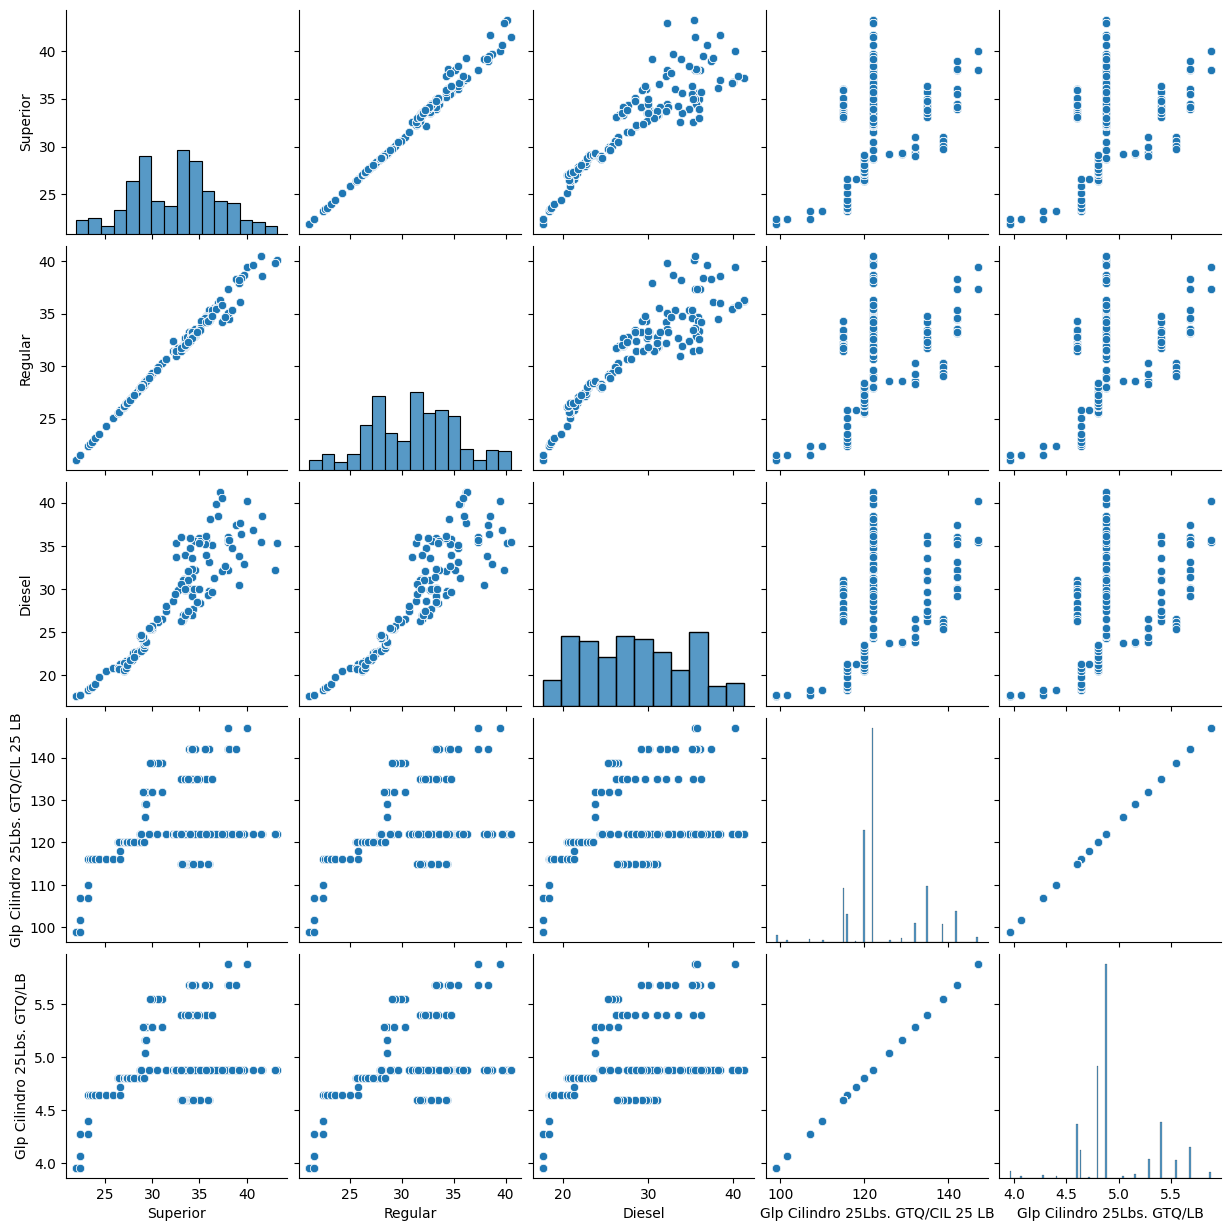

In [4]:
precios.reset_index(drop = True, inplace = True)
sns.pairplot(precios[dt_cuan])
plt.show()

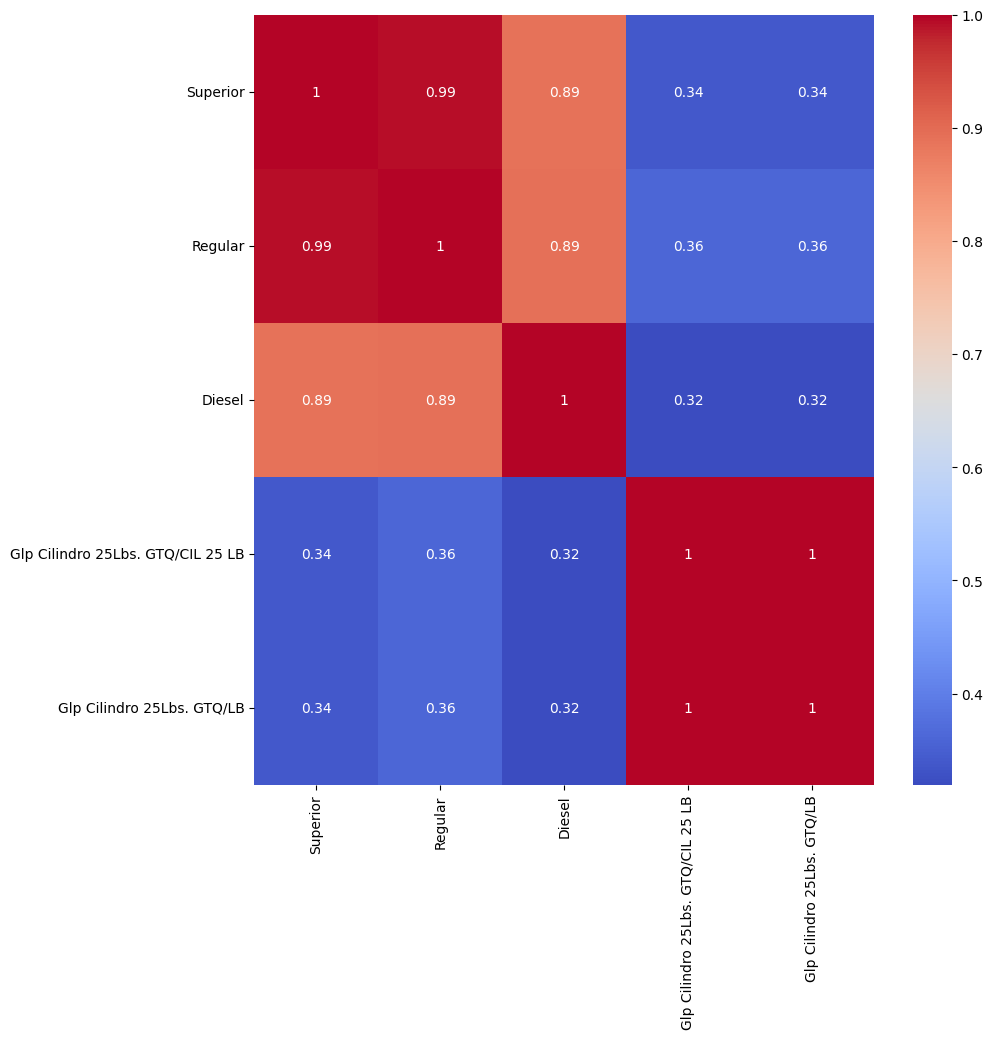

In [5]:
correlation_matrix = precios_numerics.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Al observar los histogramas realizados es posible observar que ninguna variable sigue una distribucion normal. Por otro lado en cuanto a los digramas de dispersion se puede observar que hay variables que tienen un correlación muy fuerte. Por ejemplo las variables gasolina regular y gasolina superior presentan valor de correlación de 0.99 y la variable de diesel presenta un valor de 0.89 con las dos variables mencionadas anteriormente

In [6]:
nans_por_columna = precios.isna().sum()
print(nans_por_columna)

FECHA                                0
Superior                             0
Regular                              0
Diesel                               0
Glp Cilindro 25Lbs. GTQ/CIL 25 LB    0
Glp Cilindro 25Lbs. GTQ/LB           0
dtype: int64


In [7]:
normality_precios = precios_numerics.apply(normaltest)
print(normality_precios)

    Superior   Regular        Diesel  Glp Cilindro 25Lbs. GTQ/CIL 25 LB  \
0  13.693900  8.744152  1.781288e+02                       6.549501e+01   
1   0.001063  0.012625  2.088471e-39                       5.997065e-15   

   Glp Cilindro 25Lbs. GTQ/LB  
0                6.565420e+01  
1                5.538240e-15  


En el dataset de precios las variables de interes no parecen seguir una distribución normal debido al valor bajo de p.

In [8]:
# Agregar graficas

### Importacion

In [9]:
importaciones.columns
importaciones_cuant = ["Gas licuado de petróleo","Gasolina regular","Gasolina superior","Diesel alto azufre","Total importación"]

C:\Users\Jonat\AppData\Local\Temp\ipykernel_44072\601476399.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_df[column] = import_df[column].apply(limpiar_y_convertir_a_float)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


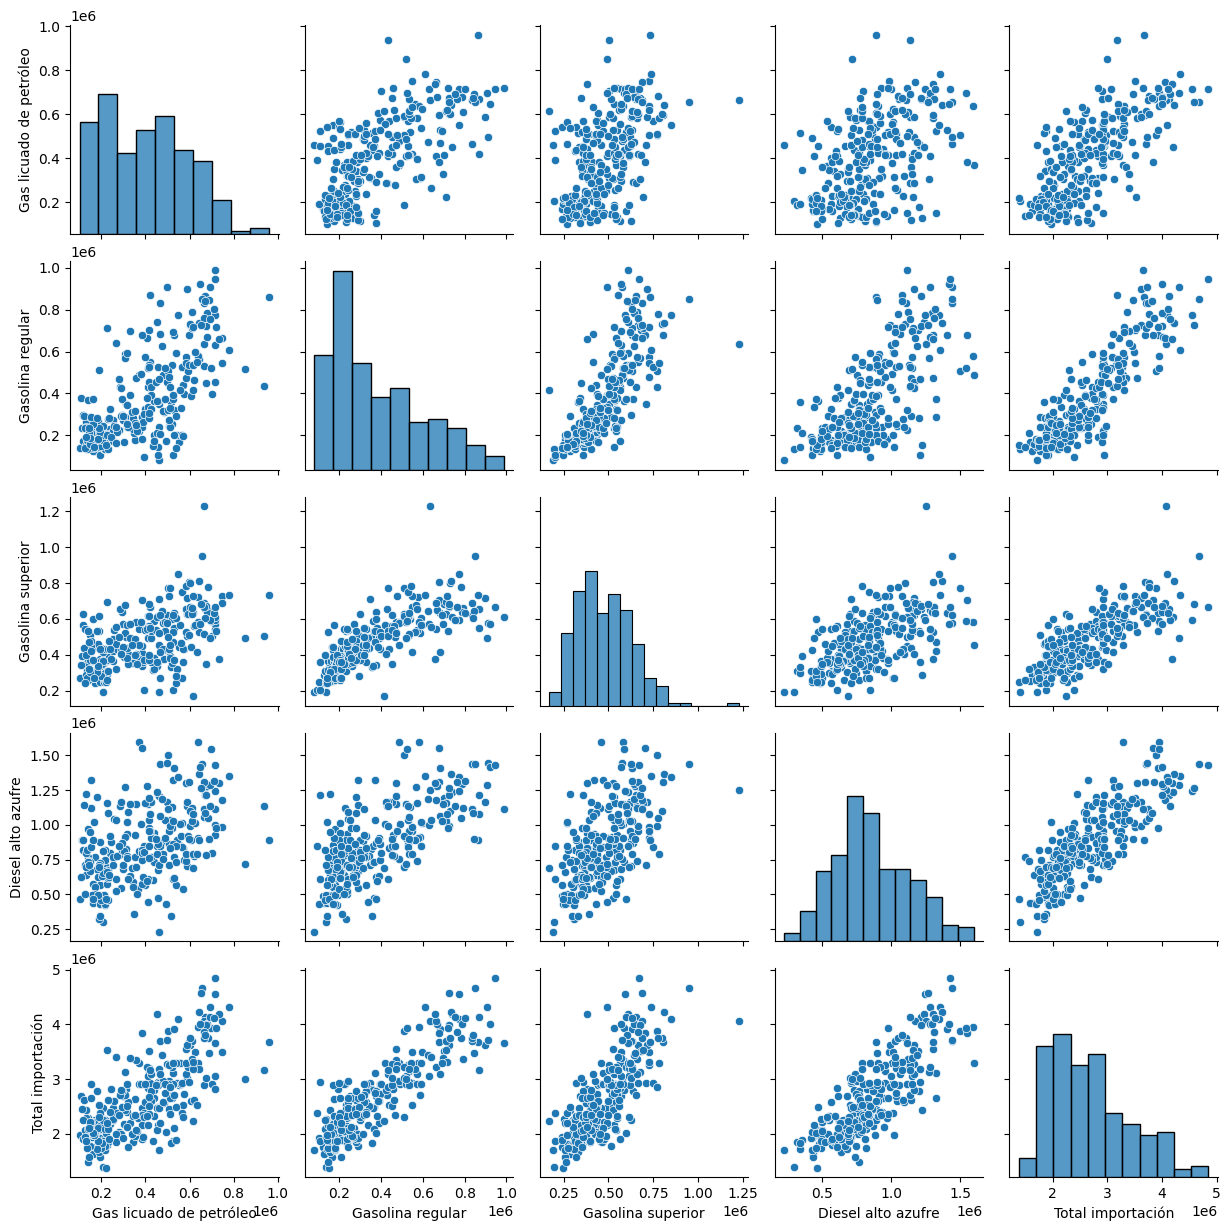

In [10]:
def limpiar_y_convertir_a_float(valor_str):
    return float(valor_str.replace(',', ''))

import_df = importaciones[importaciones_cuant]
#import_df.head()
#import_df.info()
for column in import_df.columns:
    import_df[column] = import_df[column].apply(limpiar_y_convertir_a_float)

sns.pairplot(import_df)
plt.show()

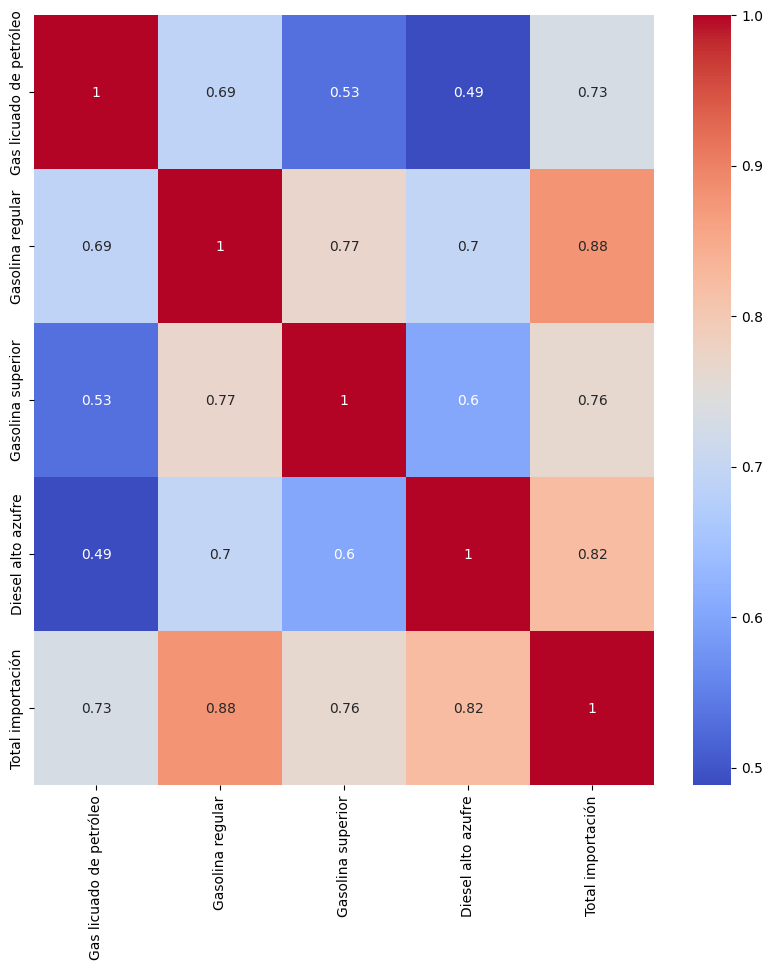

In [11]:
correlation_matrix = import_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Al observar los diagramas de dispersion y la matriz de correlación es posible observar que las variables de interes cuentan con una fuerte correlación entre sí, con valores de 0.5 hacia arriba. En cuanto a a si los datos siguen una distrución normal será necesario hacer un test de normalidad, ya que los histogramas no son suficientes para determinar si los datos siguen una distribución normal.

In [12]:
# Meses en los que más importaciones hay
for column in importaciones.columns:
    if column == 'Fecha':
       importaciones['Fecha'] = importaciones['Fecha'].replace({'ene-': 'Jan-','feb-': 'Feb-','mar-': 'Mar-','abr-': 'Apr-','may-': 'May-','jun-': 'Jun-','jul-': 'Jul-','ago-': 'Aug-','sep-': 'Sep-','oct-': 'Oct-','nov-': 'Nov-','dic-': 'Dec-'}, regex=True)
       importaciones['Fecha'] = pd.to_datetime(importaciones['Fecha'], format='%b-%y')
    else:
        importaciones[column] = importaciones[column].apply(limpiar_y_convertir_a_float)


In [13]:
nans_por_columna = importaciones.isna().sum()
print(nans_por_columna)

Fecha                      0
Gas licuado de petróleo    0
Gasolina regular           0
Gasolina superior          0
Diesel alto azufre         0
Total importación          0
dtype: int64


In [14]:
normality_importaciones = import_df.apply(normaltest)
print(normality_importaciones)

   Gas licuado de petróleo  Gasolina regular  Gasolina superior  \
0                25.680181         26.731272          27.221501   
1                 0.000003          0.000002           0.000001   

   Diesel alto azufre  Total importación  
0            7.133463          17.722492  
1            0.028248           0.000142  


Despues de realizar el test de normalidad sobre las diferentes variables de interes se puede observar que ninguna de ellas sigue una distribucion normal, debido a los valores de p-value obtenidos. 

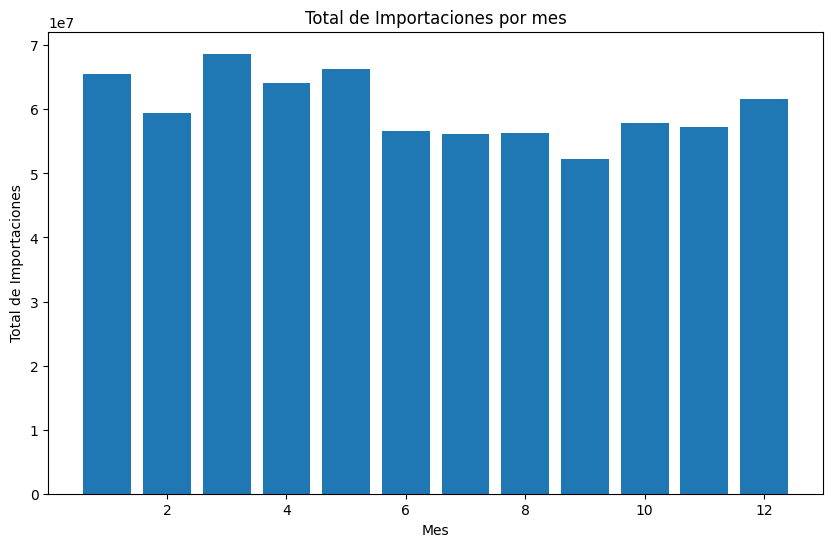

In [15]:

importaciones['Month'] = importaciones['Fecha'].dt.month

month_imports = importaciones.groupby('Month')['Total importación'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(month_imports.index, month_imports.values)
plt.title('Total de Importaciones por mes')
plt.xlabel('Mes')
plt.ylabel('Total de Importaciones')
plt.show()


En esta gráfica se puede ver que el mes con más importaciones es el mes de marzo, seguido por el mes de enero y mayo. El mes con menos importaciones es septiembre.

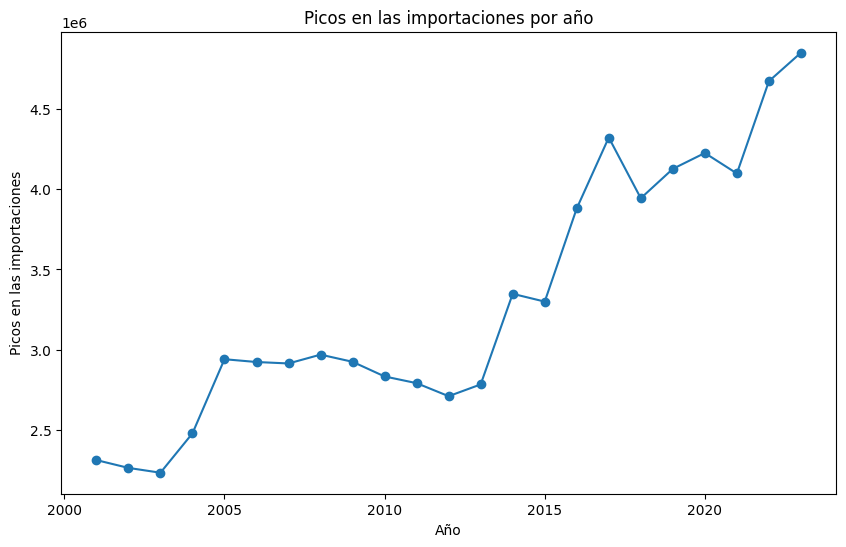

In [16]:
importaciones['Year'] = importaciones['Fecha'].dt.year
year_max_imports = importaciones.groupby('Year')['Total importación'].max()
plt.figure(figsize=(10, 6))
plt.plot(year_max_imports.index, year_max_imports.values, marker='o')
plt.title('Picos en las importaciones por año')
plt.xlabel('Año')
plt.ylabel('Picos en las importaciones')
plt.show()


En cuanto a los picos en las importaciones el más notable es en el año 2023. Esto puede ser poruqe el 2023 es cuando finalemente todos los colegios y empresas regresaron a modalidad presencial y se necesitaba más combustible para  el transporte. 

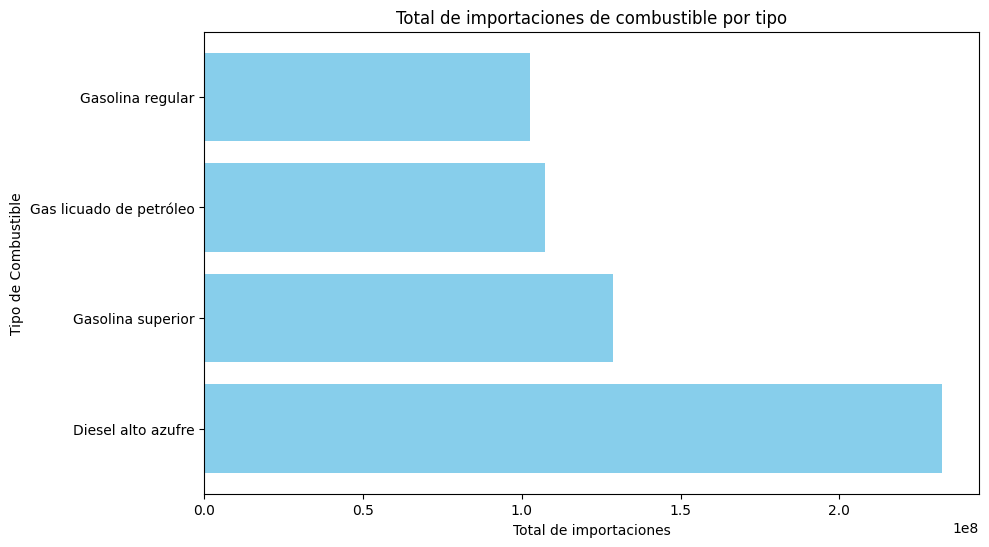

In [17]:
fuel_imports = importaciones[['Gas licuado de petróleo', 'Gasolina regular', 'Gasolina superior', 'Diesel alto azufre']].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(fuel_imports.index, fuel_imports.values, color='skyblue')
plt.title('Total de importaciones de combustible por tipo')
plt.xlabel('Total de importaciones')
plt.ylabel('Tipo de Combustible')
plt.show()

En cuanto a las al tipo de combustible más importado fue el diesel alto en azufre, mientras que la gasolina regular es la que menos se ha importado. 

### Comportamiento en los ultimos 5 años

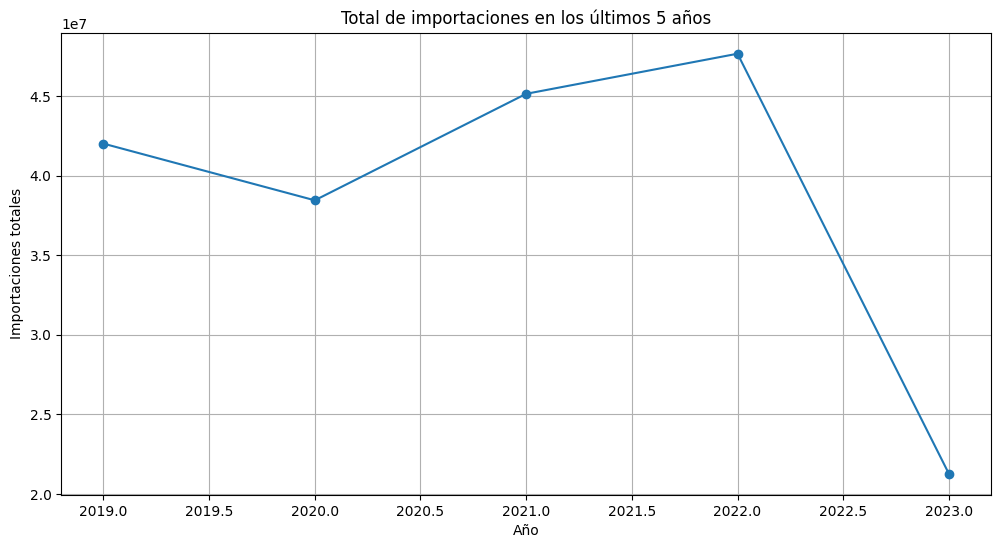

In [18]:
x = 5
recent_years_df = importaciones[importaciones['Year'] > importaciones['Year'].max() - x]
recent_years_imports = recent_years_df.groupby('Year')['Total importación'].sum()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(recent_years_imports.index, recent_years_imports.values, marker='o')
plt.title('Total de importaciones en los últimos {} años'.format(x))
plt.xlabel('Año')
plt.ylabel('Importaciones totales')
plt.grid(True)
plt.show()


Al observar la gráfica anterior se puede ver como se ha visto el total de importaciones por año. En el año 2020 se puede ver cómo el total de importaciones baja, esto puede deberse a la pandemia y que todas se vieron forzados a confinamiento. El total de importaciones vuelve a subir hasta llegar a un pico en 2022 y bajar en 2023. La caída en el 2023 se debe a que el año no se ha terminado. 

### Consumo

In [19]:
consumo = pd.read_csv('./Data/Consumo.csv')
for column in consumo.columns:
    if column == 'Fecha':
       consumo['Fecha'] = consumo['Fecha'].replace({'ene-': 'Jan-','feb-': 'Feb-','mar-': 'Mar-','abr-': 'Apr-','may-': 'May-','jun-': 'Jun-','jul-': 'Jul-','ago-': 'Aug-','sep-': 'Sep-','oct-': 'Oct-','nov-': 'Nov-','dic-': 'Dec-'}, regex=True)
       consumo['Fecha'] = pd.to_datetime(consumo['Fecha'], format='%b-%y')
    else:
        if consumo[column].dtype == 'object':
            consumo[column] = consumo[column].apply(limpiar_y_convertir_a_float)


consumo["Diesel_conjunto"] = consumo["Diesel alto azufre"] + consumo["Diesel bajo azufre"]
consumo["Diesel_conjunto"] = consumo["Diesel_conjunto"].fillna(0)
consumo["Diesel_conjunto"] = consumo["Diesel_conjunto"].astype(float)
consumo.dropna(subset=["Diesel_conjunto"], inplace=True)
nans_por_columna = consumo.isna().sum()
consumo_copy = consumo.copy()
consumo.set_index('Fecha', inplace=True)




C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


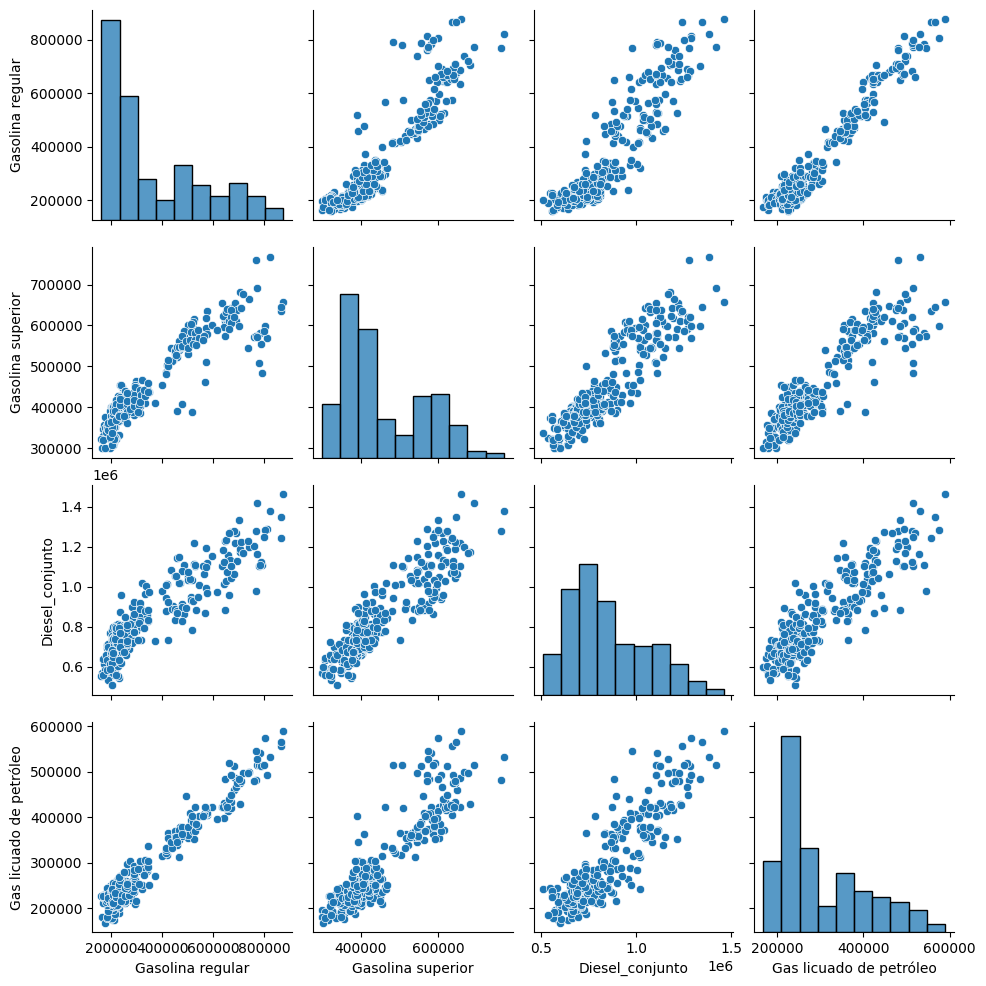

In [20]:
numerics= ["Gasolina regular", "Gasolina superior", "Diesel_conjunto", "Gas licuado de petróleo"]
consumo_numerics = consumo[numerics]

plots = sns.pairplot(consumo_numerics)
plt.show()

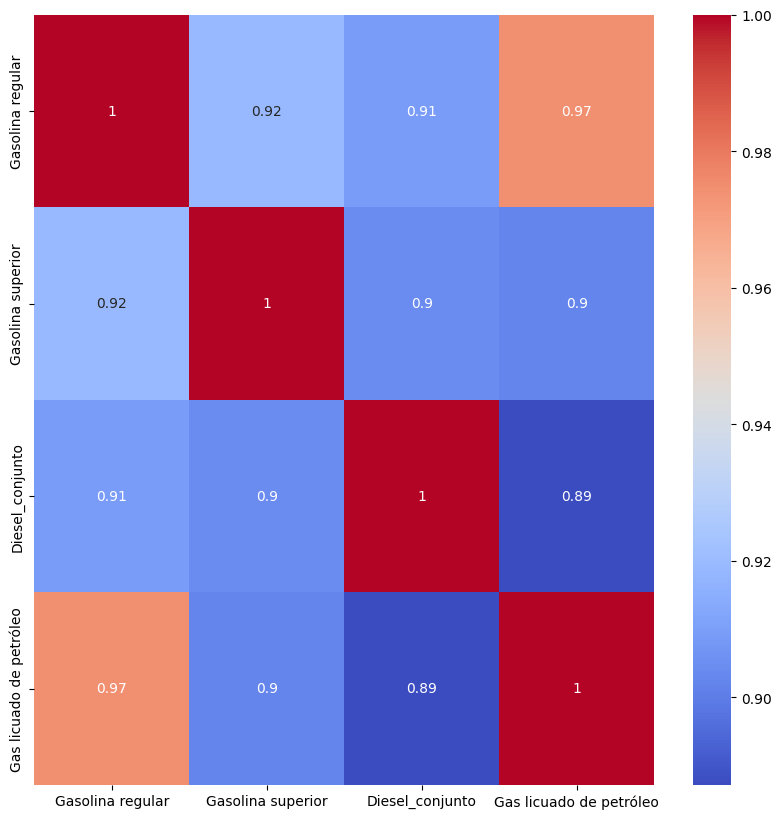

In [21]:
correlation_matrix = consumo_numerics.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

En los diagramas de dispersión realizados anteriormente se puede ver que las variables estan fuertemente relacionadas entre sí. Esto tambien es respaldado por los valores de correlación que se muestran en la matrix de correlación. Por otro lado, en los histogramas no es posible ver que las variables sigan una distribución normal, sin embargo se realizará un test de normalidad para confirmar esto.

In [22]:
normality_consumo = consumo_numerics.apply(normaltest)
print(normality_consumo)

   Gasolina regular  Gasolina superior  Diesel_conjunto  \
0      3.507221e+01       2.957783e+01        21.627472   
1      2.421952e-08       3.777945e-07         0.000020   

   Gas licuado de petróleo  
0             3.069400e+01  
1             2.162134e-07  


Despues de realizar la prueba de normalidad se puede ver que ninguna variable tiene una distribución normal debido a que el p-value es menor a 0.05, por lo tanto se puede concluir que las variables no tienen una distribución normal.

In [23]:
consumo_copy.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Mezclas\r\noleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total,Diesel_conjunto
0,2000-01-01,0.0,48446.0,296766.99,0.0,0.0,0.0,0.0,194410.48,1426.0,...,0.0,0.0,0.0,0.0,0.0,0.0,634667.06,0.0,1750544.64,634667.06
1,2000-02-01,0.0,50597.0,328116.44,0.0,0.0,0.0,0.0,174710.55,1458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,642380.66,0.0,1773220.22,642380.66
2,2000-03-01,0.0,27593.0,368589.63,0.0,0.0,0.0,0.0,189234.07,1503.0,...,0.0,0.0,0.0,0.0,0.0,0.0,699807.25,0.0,1909498.79,699807.25
3,2000-04-01,0.0,53794.0,396300.47,0.0,0.0,0.0,0.0,174330.61,1561.0,...,0.0,0.0,0.0,0.0,0.0,0.0,586803.98,0.0,1800932.86,586803.98
4,2000-05-01,0.0,60137.0,449368.92,0.0,0.0,0.0,0.0,191745.15,1642.0,...,0.0,0.0,0.0,0.0,0.0,0.0,656948.20,0.0,1941771.90,656948.20


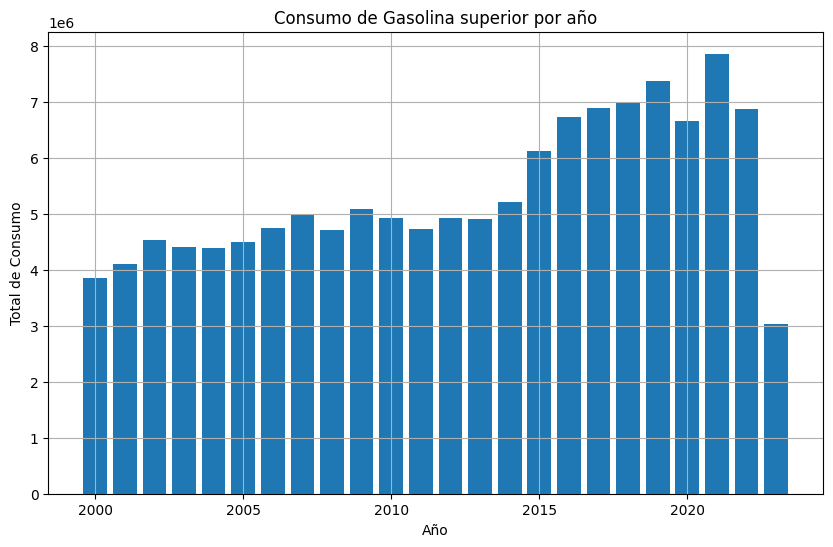

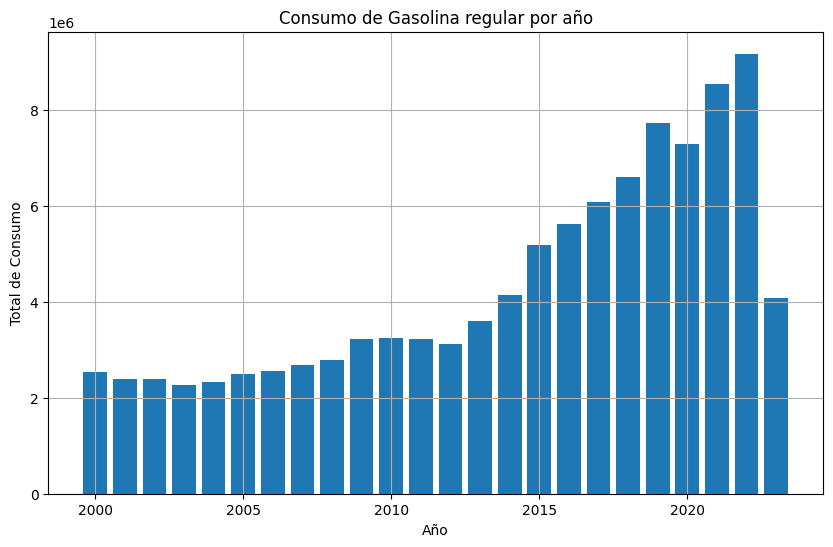

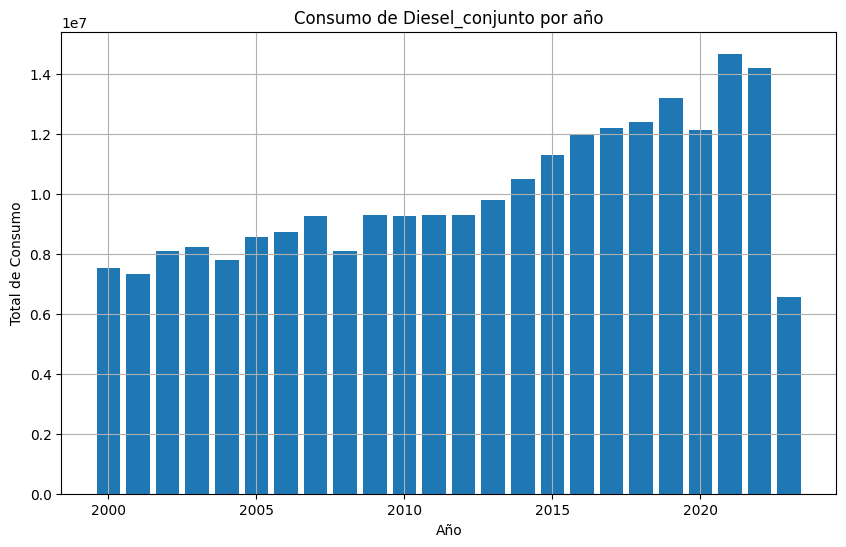

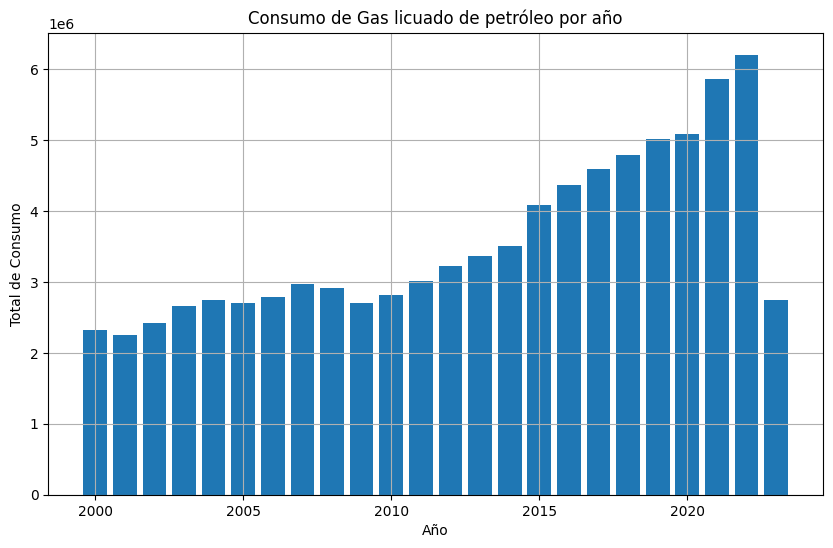

In [24]:
consumo_copy['Year'] = consumo_copy['Fecha'].dt.year
yearly_consumption = consumo_copy.groupby('Year')[['Gasolina superior', 'Gasolina regular', 'Diesel_conjunto', 'Gas licuado de petróleo']].sum()
for gasoline_type in ['Gasolina superior', 'Gasolina regular', 'Diesel_conjunto', 'Gas licuado de petróleo']:
    plt.figure(figsize=(10, 6))
    plt.bar(yearly_consumption.index, yearly_consumption[gasoline_type])
    plt.title('Consumo de {} por año'.format(gasoline_type))
    plt.xlabel('Año')
    plt.ylabel('Total de Consumo')
    plt.grid(True)
    plt.show()


En las gráficas se puede ver que el consumo que se realiza ha ido en aumento desde el 2010 y se experimenta un decenso en el año 2020, esto se puede deber a la pandemia del 2020. Despues de este año el consumo ha ido en aumento. Sin embargo, en el 2023 el consumo no se puede tomar en cuenta ya que solo se tiene una parte de todos los datos del año. 

2. Van a trabajar con 3 de las siguientes series, al menos 1 de ellas debe estimar precios:
    a. Consumo mensual de gasolina super, gasolina regular, diésel y gas licuado
    b. Importación mensual de gasolina super gasolina regular, diésel y gas licuado
    c. Precios en ciudad capital de gasolina super, gasolina regular, diésel y gas licuado

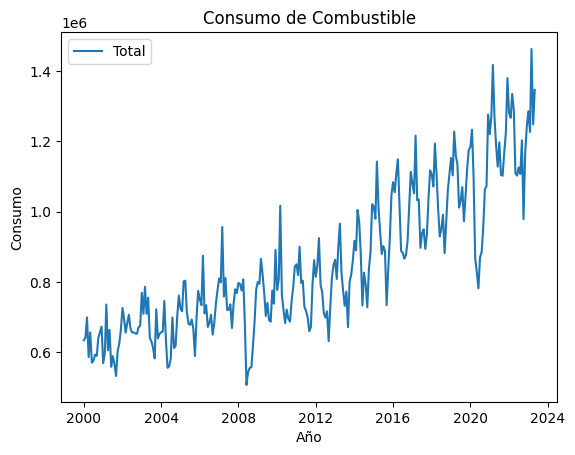

In [25]:
plt.plot(consumo_copy["Fecha"], consumo_numerics['Diesel_conjunto'], label=column)
plt.gca().set(title='Consumo de Combustible', ylabel='Consumo', xlabel='Año')
plt.legend()
plt.show()

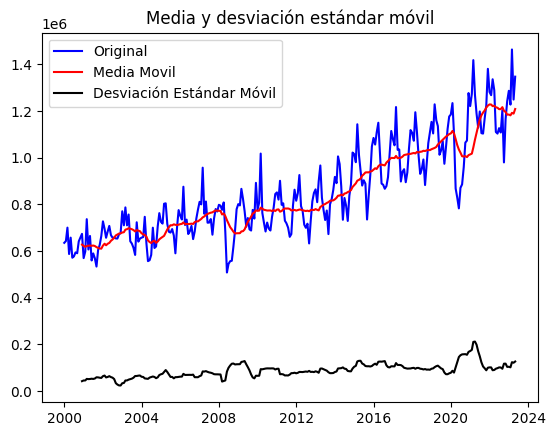

In [26]:
mediaMovil = consumo_numerics['Diesel_conjunto'].rolling(window=12).mean()
deMovil = consumo_numerics['Diesel_conjunto'].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot( consumo_copy['Fecha'], consumo_numerics['Diesel_conjunto'], color="blue", label="Original")
media = plt.plot(consumo_copy['Fecha'], mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(consumo_copy['Fecha'], deMovil, color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

In [27]:
# plt.plot(consumo["Fecha"], consumo_numerics['Gas licuado de petróleo'], label=column)
# plt.gca().set(title='Consumo de Combustible', ylabel='Consumo', xlabel='Año')
# plt.legend()
# plt.show()

In [28]:
# mediaMovil = consumo_numerics['Gas licuado de petróleo'].rolling(window=12).mean()
# deMovil = consumo_numerics['Gas licuado de petróleo'].rolling(window=12).std()
# # Se grafican los resultados.
# original = plt.plot( consumo['Fecha'], consumo_numerics['Gas licuado de petróleo'], color="blue", label="Original")
# media = plt.plot(consumo['Fecha'], mediaMovil, color='red', label = 'Media Movil')
# ds = plt.plot(consumo['Fecha'], deMovil, color='black', label = 'Desviación Estándar Móvil')
# plt.legend(loc = 'best')
# plt.title('Media y desviación estándar móvil')
# plt.show(block=False)

### Descomponiendo las series

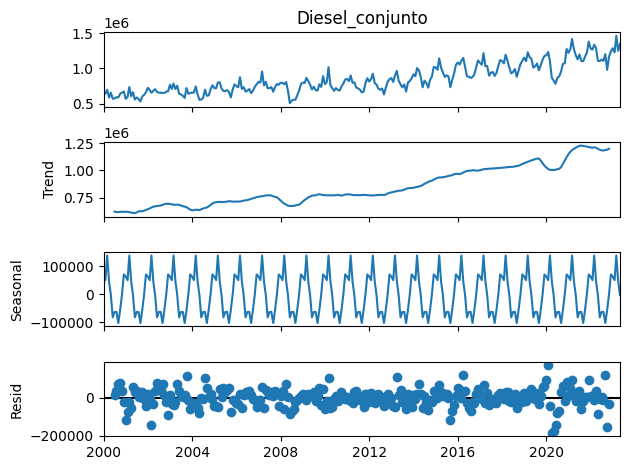

In [29]:
descomposicion = seasonal_decompose(consumo['Diesel_conjunto'])
descomposicion.plot()
plt.show()

Como la serie de tiempo muestra tendencia no es estacionaria en media ni varianza. Por lo que para estacionarizarla es necesario transformarla. 

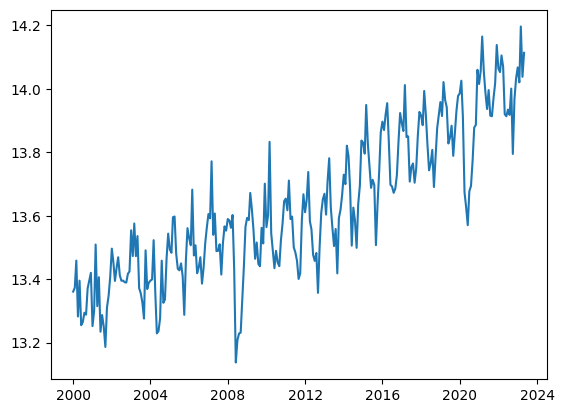

In [30]:
## Estacionalidad de la serie de tiempo
df_log= np.log(consumo['Diesel_conjunto'])
plt.plot(df_log)
plt.show()

In [31]:
from statsmodels.tsa.stattools import adfuller

# Calculate the result
result = adfuller(consumo['Diesel_conjunto'])

# Print the result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: 0.018031714019236162
p-value: 0.9599981340114369


In [32]:
diff = consumo['Diesel_conjunto'].diff()
diff.dropna(inplace=True)

result = adfuller(diff)

# Print the result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -6.8842663840036105
p-value: 1.407678805661164e-09


Dado unicamente se realizo una diferenciación, el componente D sera 1

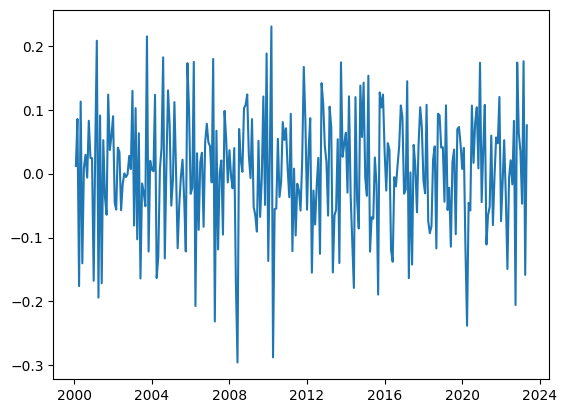

In [33]:
plt.plot(df_log.diff())
plt.show()

Según la grafica, luego de las transoformaciones aplicadas, la serie es estacionaria tanto en media como en varianza. 

In [34]:
df_log_f = df_log.diff().dropna()
df_acf = acf(df_log_f,nlags=36,fft=False)
df_pacf = pacf(df_log_f, nlags=36)


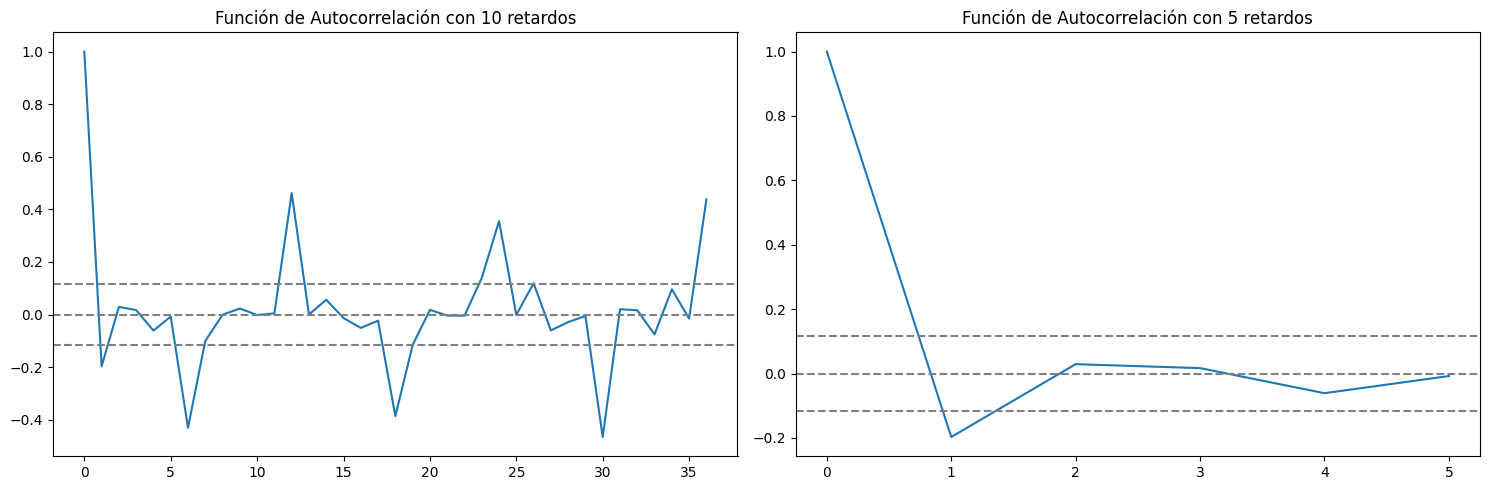

In [35]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(df_log_f,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_f)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_f)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 10 retardos')

plt.subplot(122) 
plt.plot(acf(df_log_f,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_f)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_f)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()
plt.show()

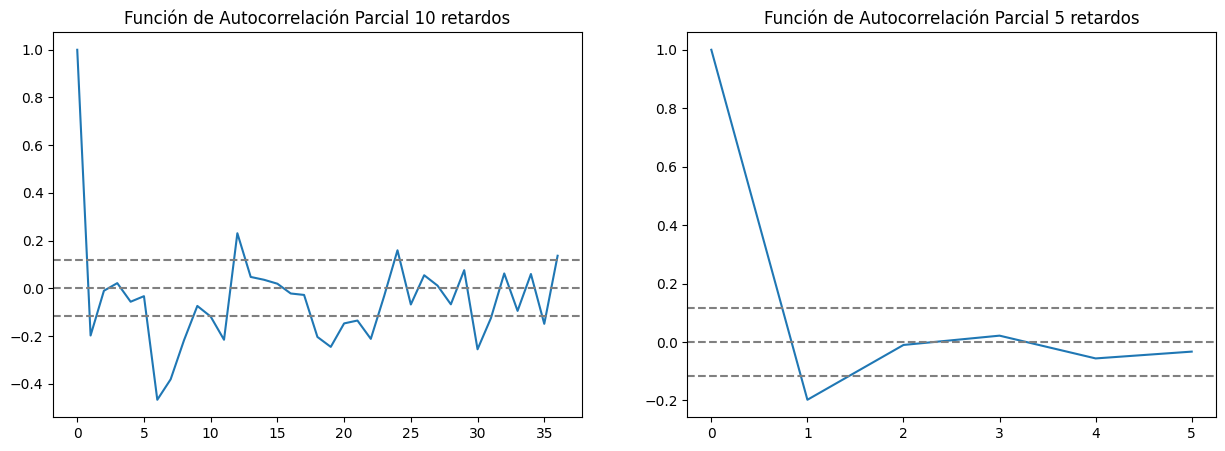

In [36]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(df_log_f, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_f)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_f)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 10 retardos')

plt.subplot(122)
plt.plot(pacf(df_log_f, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_f)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_f)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.show()

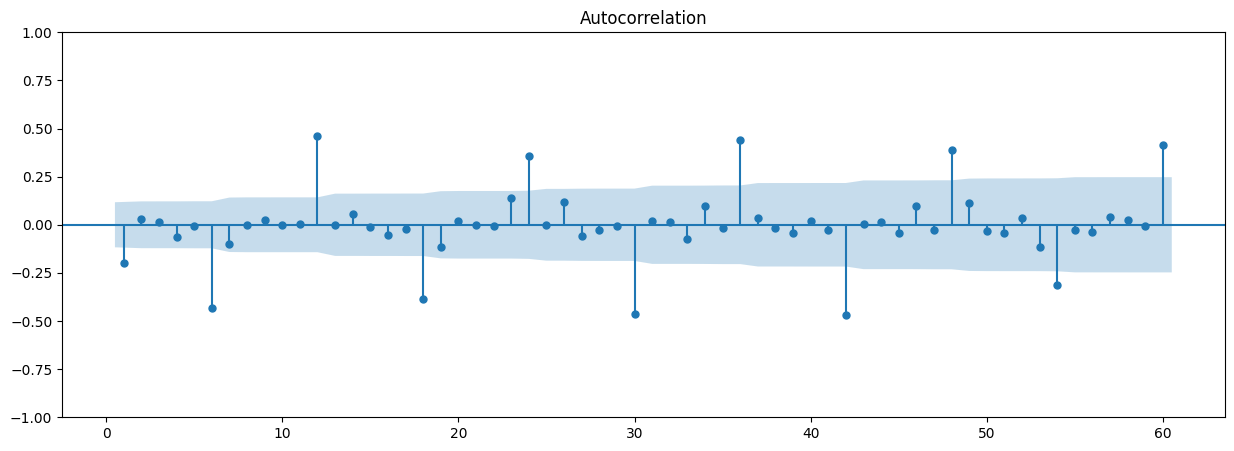

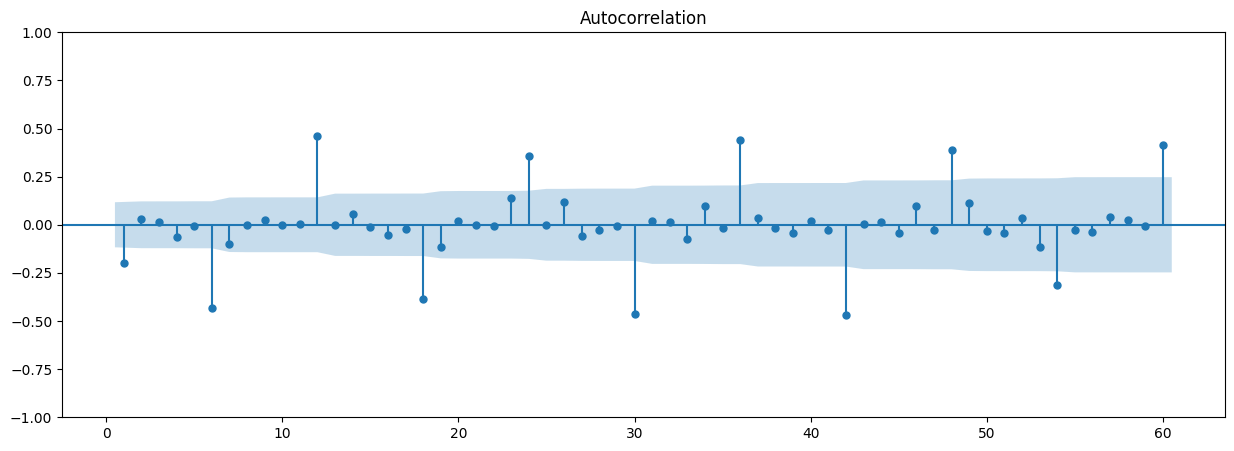

In [37]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_log_f, lags=60, zero=False)

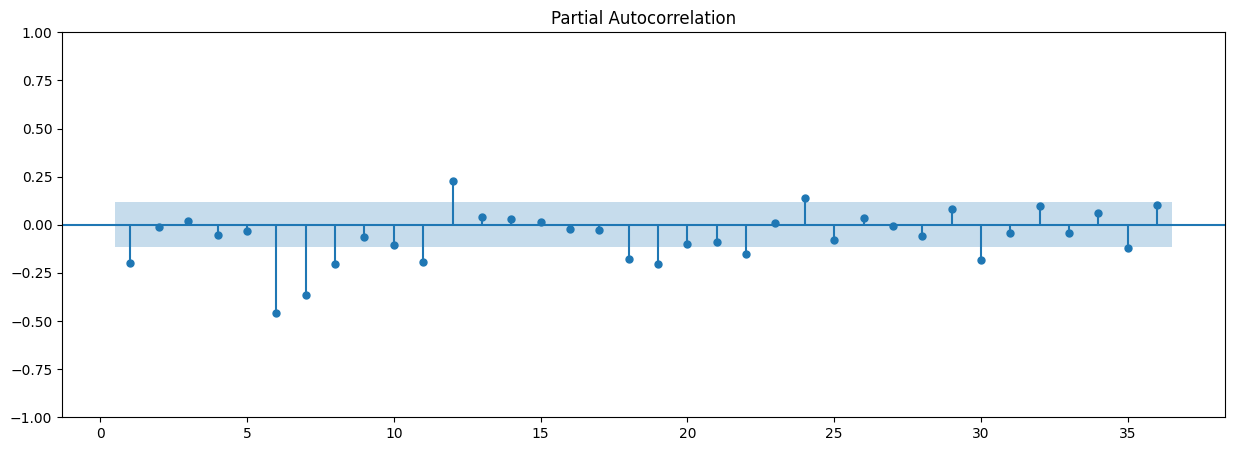

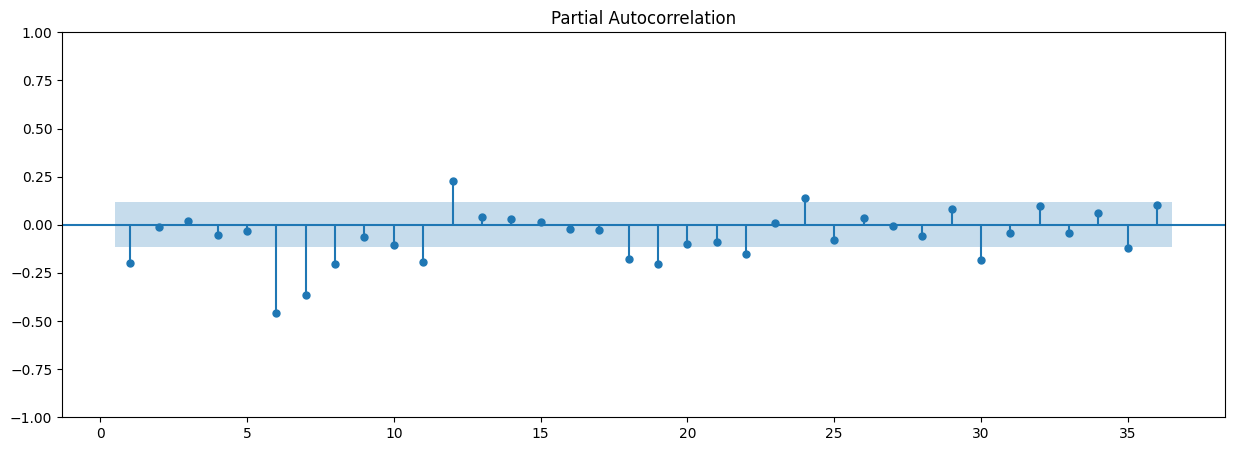

In [38]:
sm.graphics.tsa.plot_pacf(df_log_f, lags=36, zero=False)

Al observar estos dos gráficos se consideraron dos valores para probar el modelo, el primero será con 4 y con 13 ya que presentan mejores valores en los digramas de autocorrelación. 

C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Local

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4826      4.058     -0.365      0.715      -9.435       6.470
ar.L2         -1.2430      3.028     -0.411      0.681      -7.178       4.692
ar.L3         -0.9561      3.400     -0.281      0.779      -7.619       5.707
ar.L4         -0.6076      2.119     -0.287      0.774      -4.761       3.546
ar.L5         -0.1156      1.862     -0.062      0.951      -3.766       3.535
ar.L6         -0.4334      0.804     -0.539      0.590      -2.009       1.142
ar.L7         -1.1678      2.560     -0.456      0.648      -6.186       3.850
ar.L8         -1.2865      3.236     -0.398      0.691      -7.629       5.056
ar.L9         -0.9559      3.327     -0.287      0.774      -7.476       5.564
ar.L10        -0.6017      2.167     -0.278      0.781      -4.849       3.646
ar.L11        -0.0233      1.809     -0.013      0.9

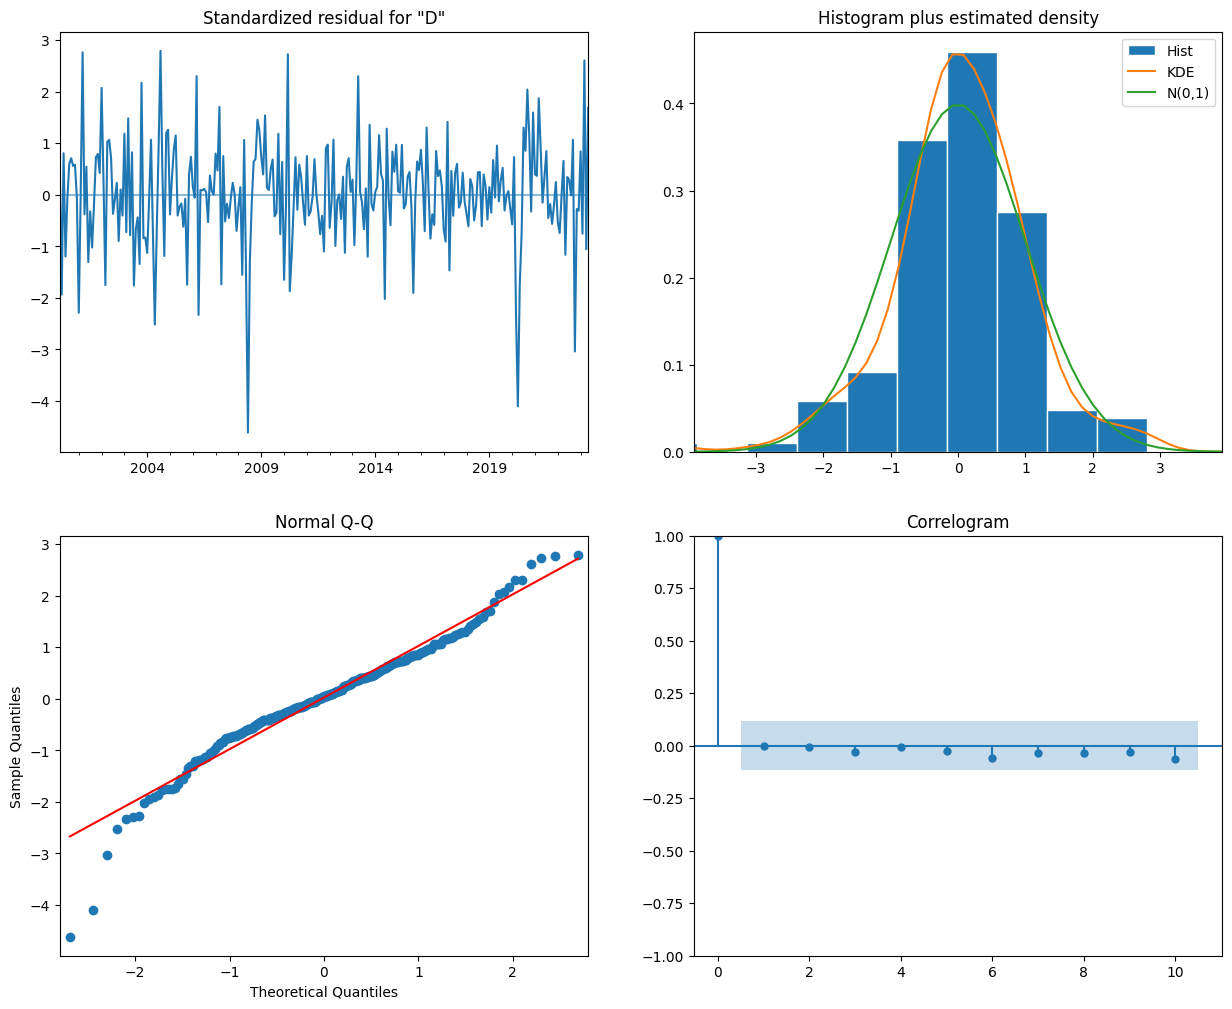

In [39]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_log_f, order=(13, 1, 13))  # p and q are the orders you've determined
results_13113 = model.fit()
print(results_13113.summary().tables[1])
results_13113.plot_diagnostics(figsize=(15, 12))
plt.show()

In [41]:
# Modelo 13, 3, 13
print("AIC:", results_13113.aic)
print("BIC:", results_13113.bic)

AIC: -653.4753814476851
BIC: -555.4326633385083


Al observar el correlograma se puede ver que hay muy pocas autocorelaciones significativas. Por otro lado, el histograma demustra que los residuos presentan una distribución normal. Sin embargo los valores muy bajos de AIC y Bic indican que el modelo prodría ser mejor por lo que se realizara un modelo con diferentes parametros. 

C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Local

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1563      0.246     -4.703      0.000      -1.638      -0.674
ar.L2         -1.2206      0.074    -16.531      0.000      -1.365      -1.076
ar.L3         -1.1006      0.241     -4.559      0.000      -1.574      -0.627
ar.L4         -0.2380      0.066     -3.599      0.000      -0.368      -0.108
ma.L1         -0.0118      0.302     -0.039      0.969      -0.604       0.580
ma.L2          0.0427      0.256      0.167      0.868      -0.459       0.545
ma.L3         -0.1859      0.273     -0.680      0.497      -0.722       0.350
ma.L4         -0.8357      0.264     -3.168      0.002      -1.353      -0.319
sigma2         0.0076      0.001      5.645      0.000       0.005       0.010


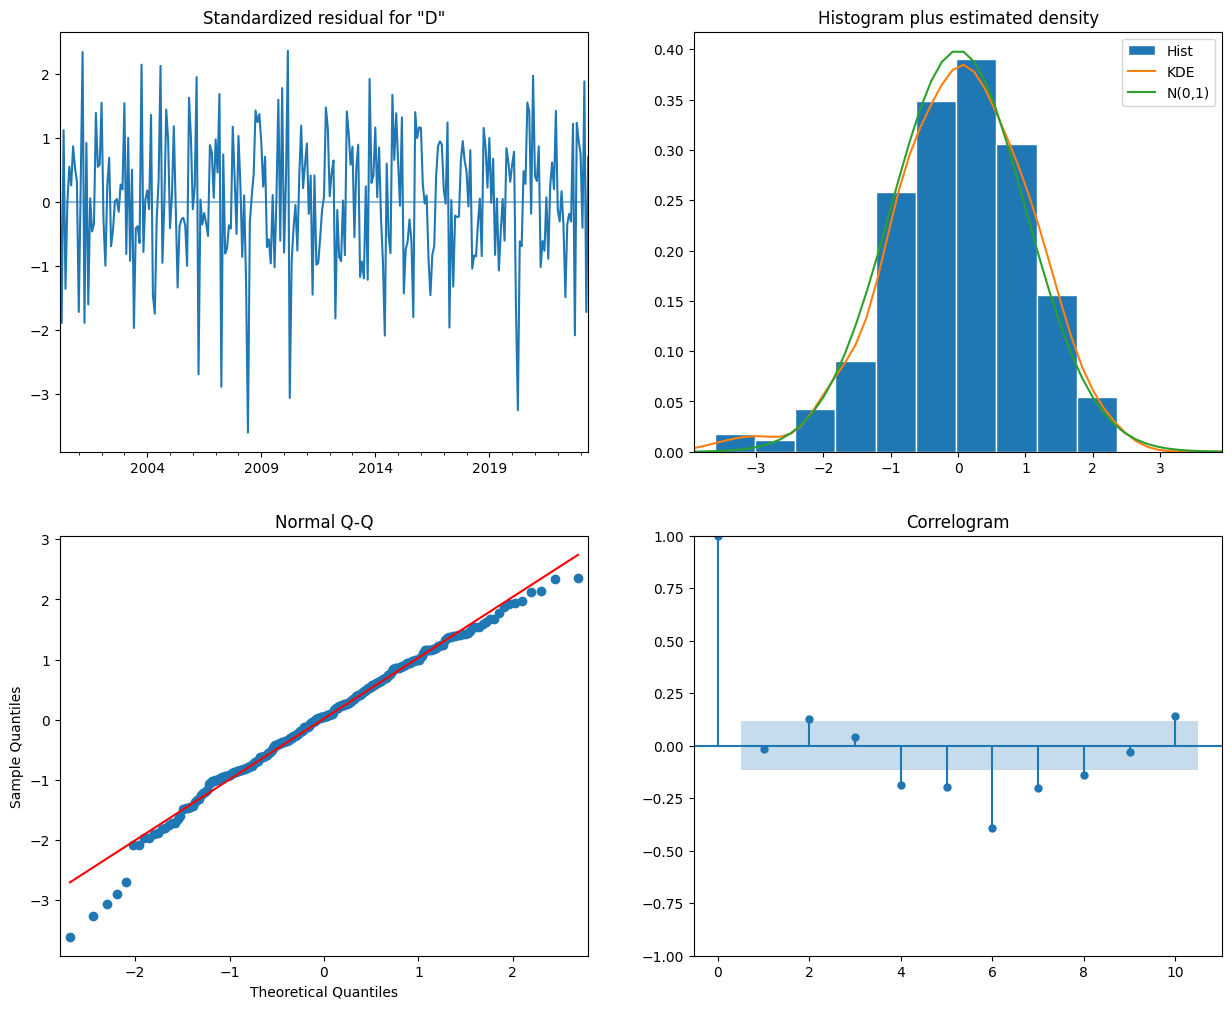

In [42]:
model = ARIMA(df_log_f, order=(4, 1, 4))  # p and q are the orders you've determined
results_414 = model.fit()
print(results_414.summary().tables[1])
results_414.plot_diagnostics(figsize=(15, 12))
plt.show()

In [99]:
print("AIC:", results_414.aic)
print("BIC:", results_414.bic)

AIC: -539.016557213054
BIC: -506.33565117666177


En este segundo modelo se puede ver como el segundo modelo tambien presenta los residuos en una distribucion normal. Tambien el correlograma no presenta autocorrelaciones significativas. En este modelo los valores de AIC y BIC se hicieron más grandes, demostrando que el modelo anterior es mejor. Sin embargo, en ambos casos los valores sonmuy negativos. 

## Prophet


In [78]:
from prophet import Prophet

df = pd.DataFrame(consumo['Diesel_conjunto'])
df = df.reset_index()


In [130]:
df = df.rename(columns={'Fecha': 'ds',
                        'Diesel_conjunto': 'y'})

train = df[df['ds'] <= '2020-12-31']
test = df[(df['ds'] >= '2021-01-01') & (df['ds'] <= '2023-12-31')]

df.tail(20)


,ds,y
261,2021-10-01,1166983.39
262,2021-11-01,1223817.11
263,2021-12-01,1380064.62
264,2022-01-01,1281083.25
265,2022-02-01,1267195.10
266,2022-03-01,1335367.84
267,2022-04-01,1288232.70
268,2022-05-01,1109576.77
269,2022-06-01,1102689.46
270,2022-07-01,1125984.15


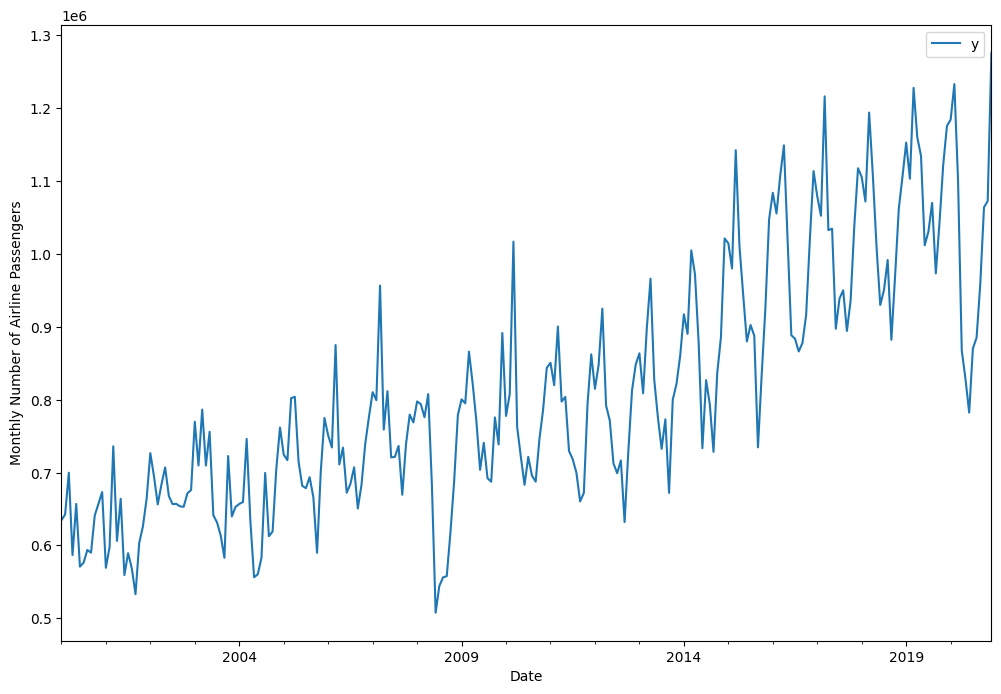

In [113]:
ax = train.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')
plt.show()

In [152]:
m = Prophet(interval_width=0.95)
m.fit(train)

04:09:22 - cmdstanpy - INFO - Chain [1] start processing
04:09:22 - cmdstanpy - INFO - Chain [1] done processing


In [181]:
future_dates = m.make_future_dataframe(periods=29, freq='MS')


In [154]:
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
261,2021-10-01,1.078290e+06,9.607682e+05,1.191930e+06
262,2021-11-01,1.131108e+06,1.018172e+06,1.253222e+06
263,2021-12-01,1.203408e+06,1.088758e+06,1.325240e+06
264,2022-01-01,1.193208e+06,1.070220e+06,1.319835e+06
265,2022-02-01,1.183237e+06,1.063528e+06,1.295124e+06
266,2022-03-01,1.273468e+06,1.163163e+06,1.387693e+06
267,2022-04-01,1.175477e+06,1.050676e+06,1.292141e+06
268,2022-05-01,1.149502e+06,1.028855e+06,1.270194e+06
269,2022-06-01,1.067700e+06,9.480458e+05,1.187311e+06
270,2022-07-01,1.086632e+06,9.749932e+05,1.188838e+06


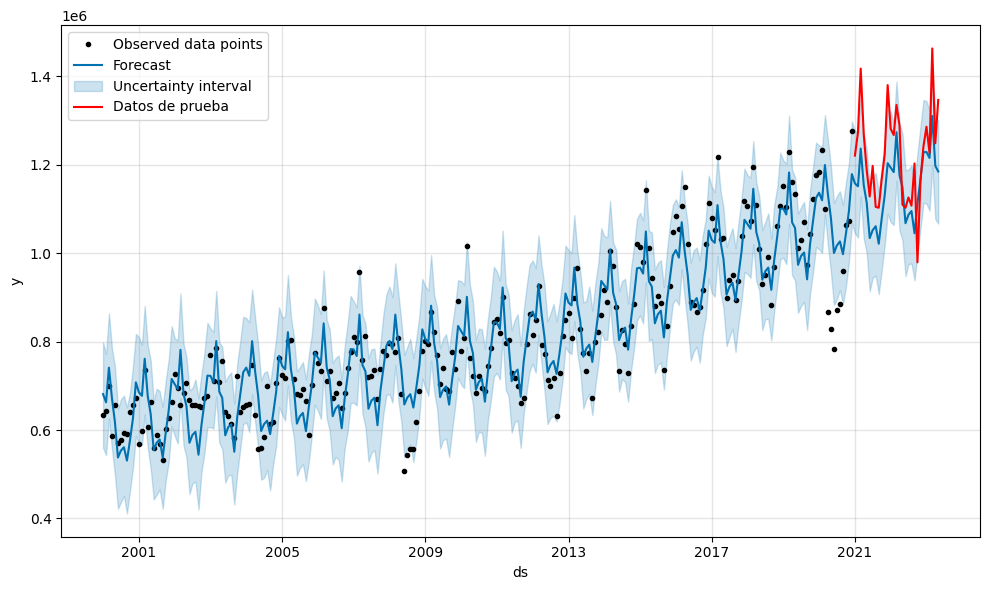

In [155]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)

# Agregar una línea continua para los datos de prueba al gráfico
plt.plot(test['ds'], test['y'], color='red', label='Datos de prueba')
plt.legend()
plt.show()

In [156]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Fusionar las predicciones con el conjunto de prueba
merged = forecast.merge(test, on='ds', how='right')
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
print("RMSE:", rmse)


RMSE: 100115.69824121307


## Segunda Serie


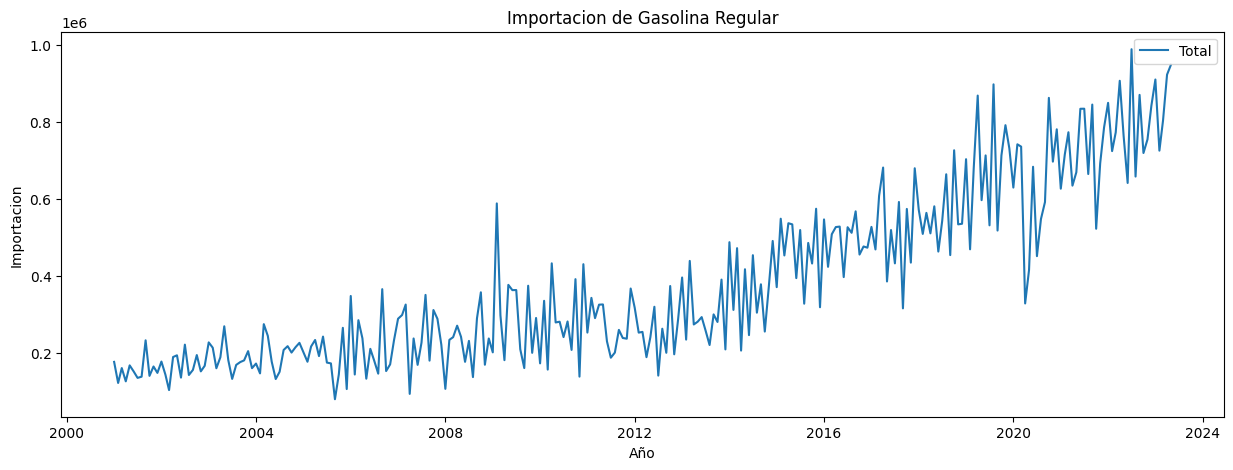

In [44]:
plt.plot(importaciones["Fecha"], importaciones['Gasolina regular'], label=column)
plt.gca().set(title='Importacion de Gasolina Regular', ylabel='Importacion', xlabel='Año')
plt.legend()
plt.show()

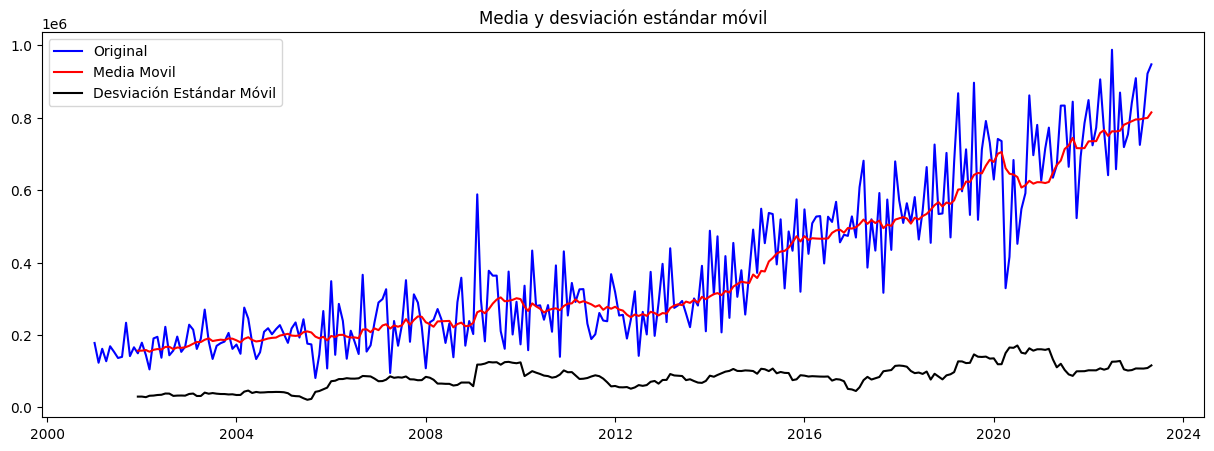

In [45]:
mediaMovil = importaciones['Gasolina regular'].rolling(window=12).mean()
deMovil = importaciones['Gasolina regular'].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot( importaciones['Fecha'], importaciones['Gasolina regular'], color="blue", label="Original")
media = plt.plot(importaciones['Fecha'], mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(importaciones['Fecha'], deMovil, color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

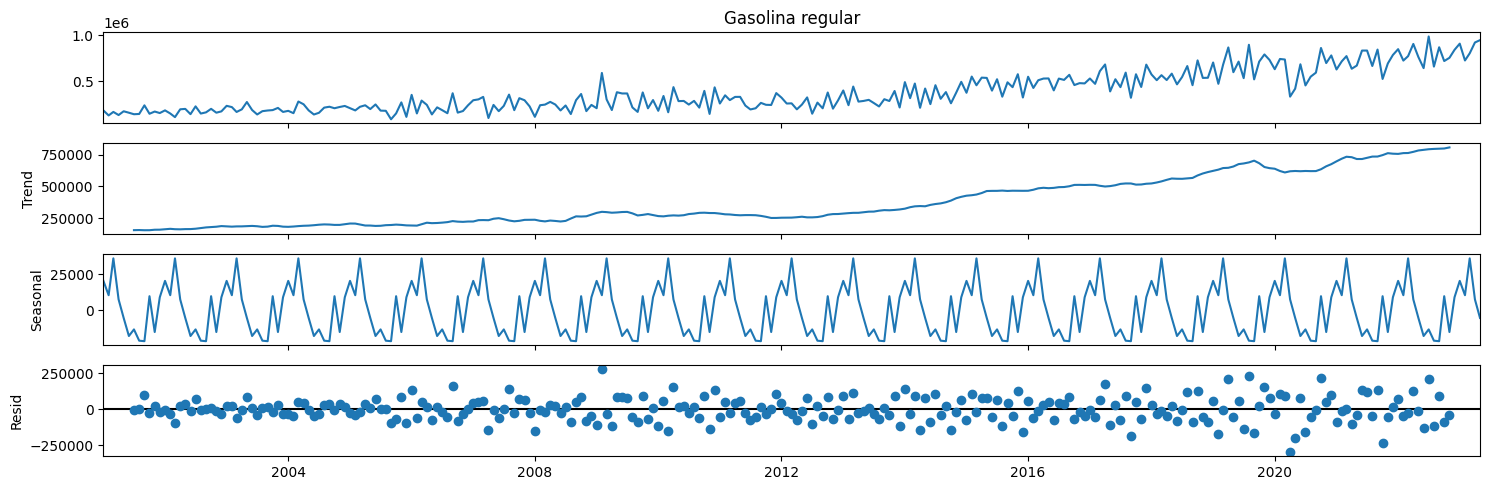

In [46]:
importacions_copy = importaciones.copy()
importacions_copy.set_index('Fecha', inplace=True)
descomposicion = seasonal_decompose(importacions_copy['Gasolina regular'])
descomposicion.plot()
plt.show()

Al realizar la descomposición de la serie se puede observar que presenta una tendencia. Esto nos indinca que la serie no es estacionaria ni en media ni en varianza. Para arreglar esto es necesario aplicar transformaciones. 

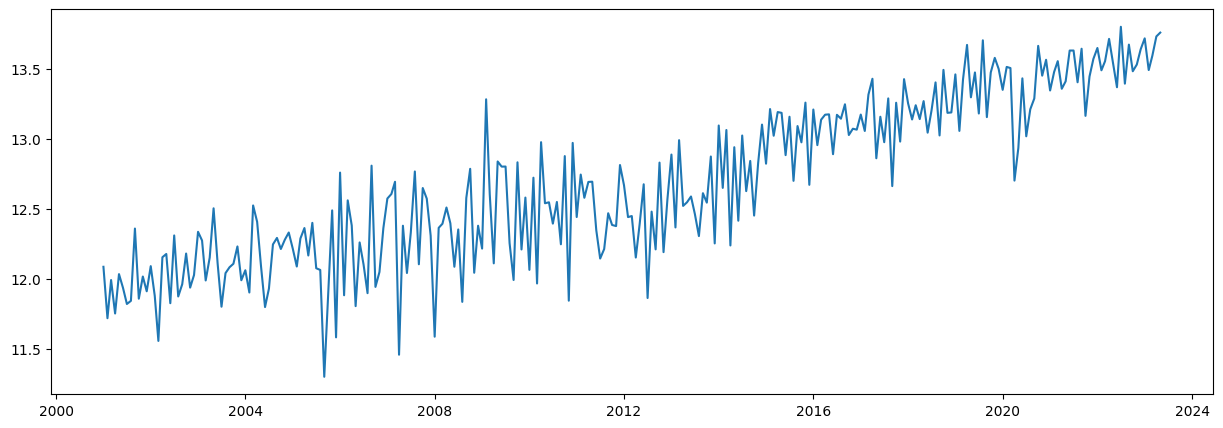

In [47]:
df_log_i = np.log(importacions_copy['Gasolina regular'])
plt.plot(df_log_i)
plt.show()

In [48]:
# Calculate the result
result = adfuller(importacions_copy['Gasolina regular'])

# Print the result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 1.0907483377654654
p-value: 0.9951368848202486


El p-value no es menor a 0.05 por lo que es necesario realizar una diferenciación para volver estacionaria en varianza. 

In [49]:
diff = importacions_copy['Gasolina regular'].diff()
diff.dropna(inplace=True)

result = adfuller(diff)

# Print the result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -9.85286803959334
p-value: 4.437791450957939e-17


Ahora que el p-value es menor a 0.05 ya es posible graficar la serie con la transformación. 

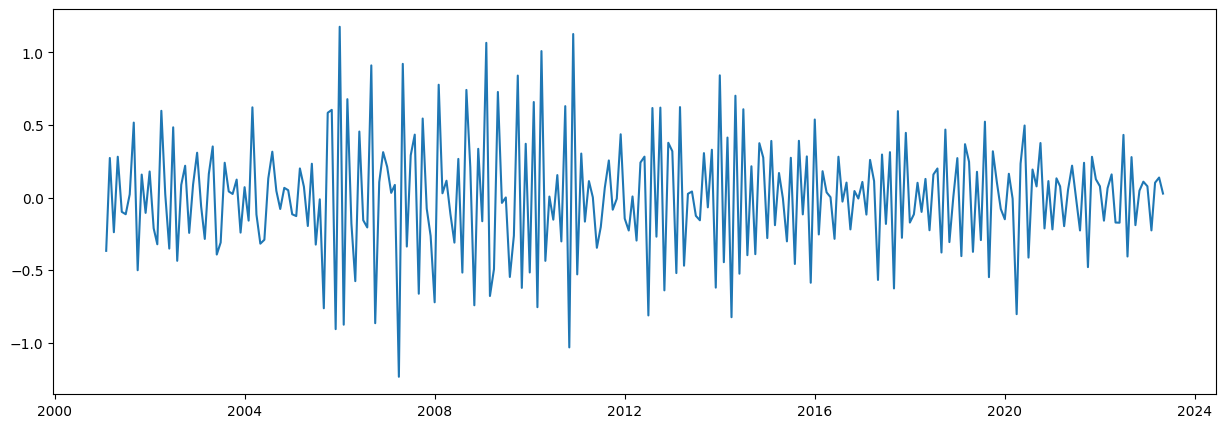

In [50]:
plt.plot(df_log_i.diff())
plt.show()

Es posible ver como la grafica ahora ya es estacionaria en varianza y en media tambien, despues de las transformaciones realizadas. 

In [51]:
df_log_f_i = df_log_i.diff().dropna()
df_acf = acf(df_log_f_i,nlags=36,fft=False)
df_pacf = pacf(df_log_f_i, nlags=36)

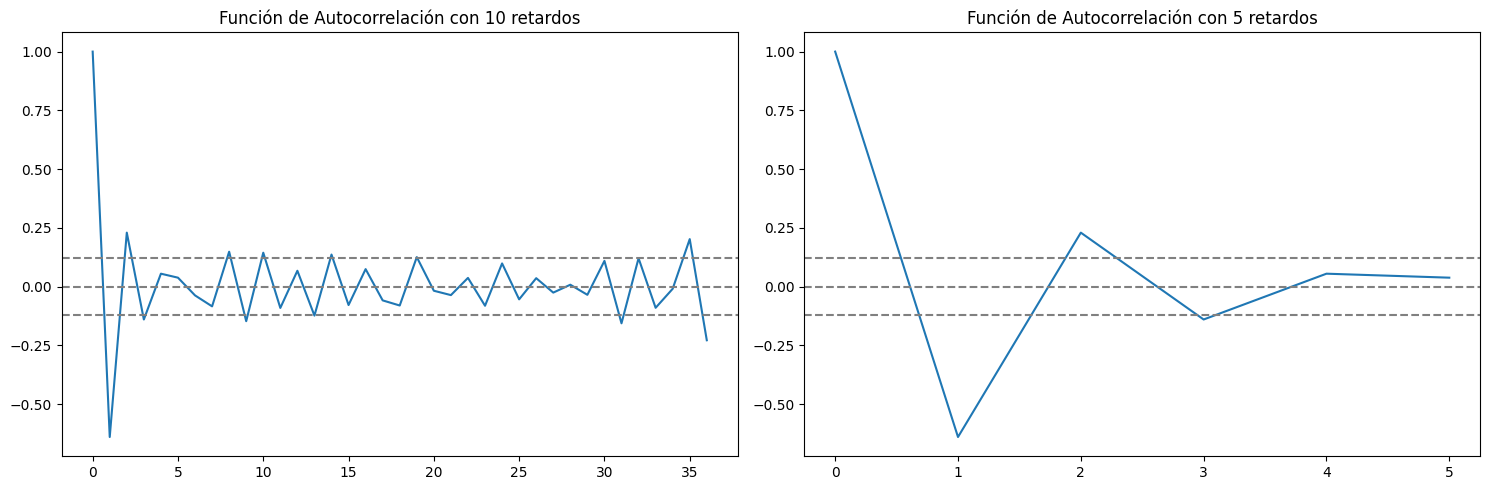

In [52]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(df_log_f_i,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_f_i)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_f_i)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 10 retardos')

plt.subplot(122) 
plt.plot(acf(df_log_f_i,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_f_i)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_f_i)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()
plt.show()

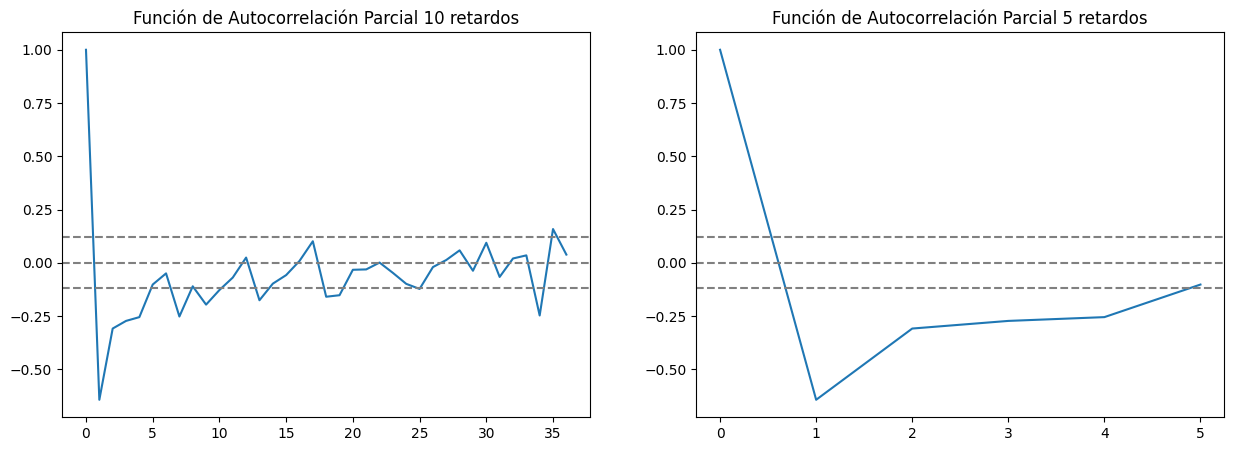

In [53]:
plt.subplot(121)
plt.plot(pacf(df_log_f_i, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_f_i)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_f_i)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 10 retardos')

plt.subplot(122)
plt.plot(pacf(df_log_f_i, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_f_i)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_f_i)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.show()

Al ver los diagramas de autocorrelacion se puede ver que ambos graficos despues de los valores de 3 y 5 parecen normalizarse las el comportamiento de la grafica. Es por eso que utilizaremos ese valor para el modelo. 

C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Local

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7601      0.067    -11.346      0.000      -0.891      -0.629
ar.L2         -1.0201      0.051    -20.196      0.000      -1.119      -0.921
ar.L3         -0.6299      0.055    -11.518      0.000      -0.737      -0.523
ma.L1         -0.9130      0.233     -3.911      0.000      -1.370      -0.455
ma.L2          0.8070      0.094      8.593      0.000       0.623       0.991
ma.L3         -0.8876      0.225     -3.950      0.000      -1.328      -0.447
sigma2         0.0917      0.022      4.238      0.000       0.049       0.134


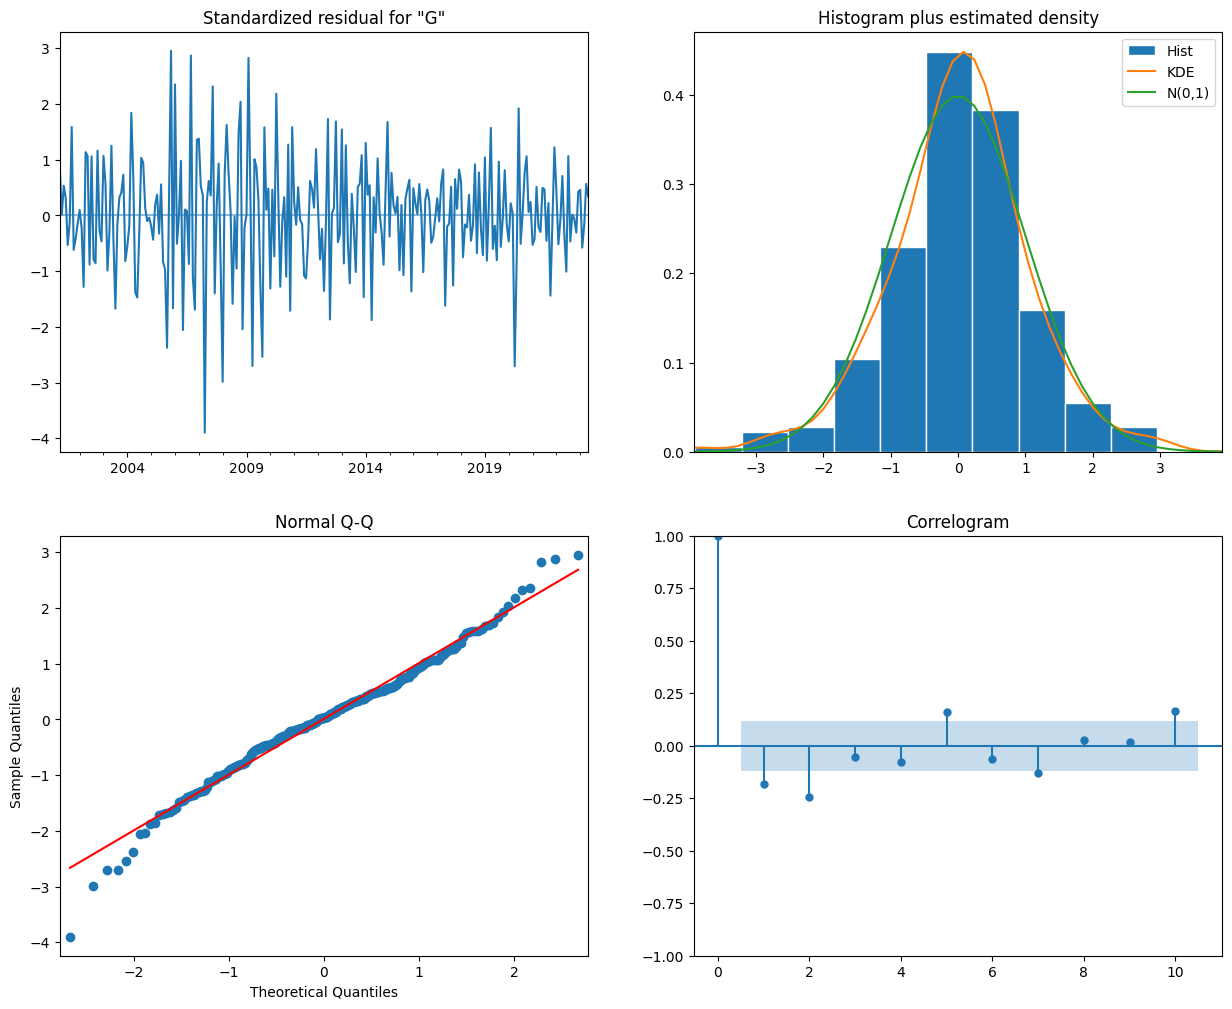

In [54]:
model = ARIMA(df_log_f_i, order=(3, 1, 3))  # p and q are the orders you've determined
results_313 = model.fit()
print(results_313.summary().tables[1])
results_313.plot_diagnostics(figsize=(15, 12))
plt.show()

In [55]:
print("AIC:", results_313.aic)
print("BIC:", results_313.bic)

AIC: 140.5180691180736
BIC: 165.62880972687537


En este modelo que los residuos asemejan una distribución normal. Ademas que las autocorrelaciones presentadas por el correlograma son insignificantes. Por lo que lo que nos interesa es ver los valores de AIC y BIC los cuales son bastante altos. Sin embargo se experimentara con otro modelo para observar cual se comporta mejor. 

C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Local

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1805      0.133    -16.376      0.000      -2.442      -1.920
ar.L2         -2.1949      0.232     -9.455      0.000      -2.650      -1.740
ar.L3         -1.1009      0.262     -4.198      0.000      -1.615      -0.587
ar.L4         -0.0542      0.172     -0.315      0.753      -0.392       0.283
ar.L5          0.0434      0.066      0.658      0.510      -0.086       0.173
ma.L1          0.1074      0.145      0.739      0.460      -0.177       0.392
ma.L2         -0.9564      0.151     -6.345      0.000      -1.252      -0.661
ma.L3         -1.0376      0.184     -5.653      0.000      -1.397      -0.678
ma.L4         -0.0213      0.130     -0.163      0.870      -0.277       0.234
ma.L5          0.9086      0.166      5.485      0.000       0.584       1.233
sigma2         0.0641      0.010      6.377      0.0

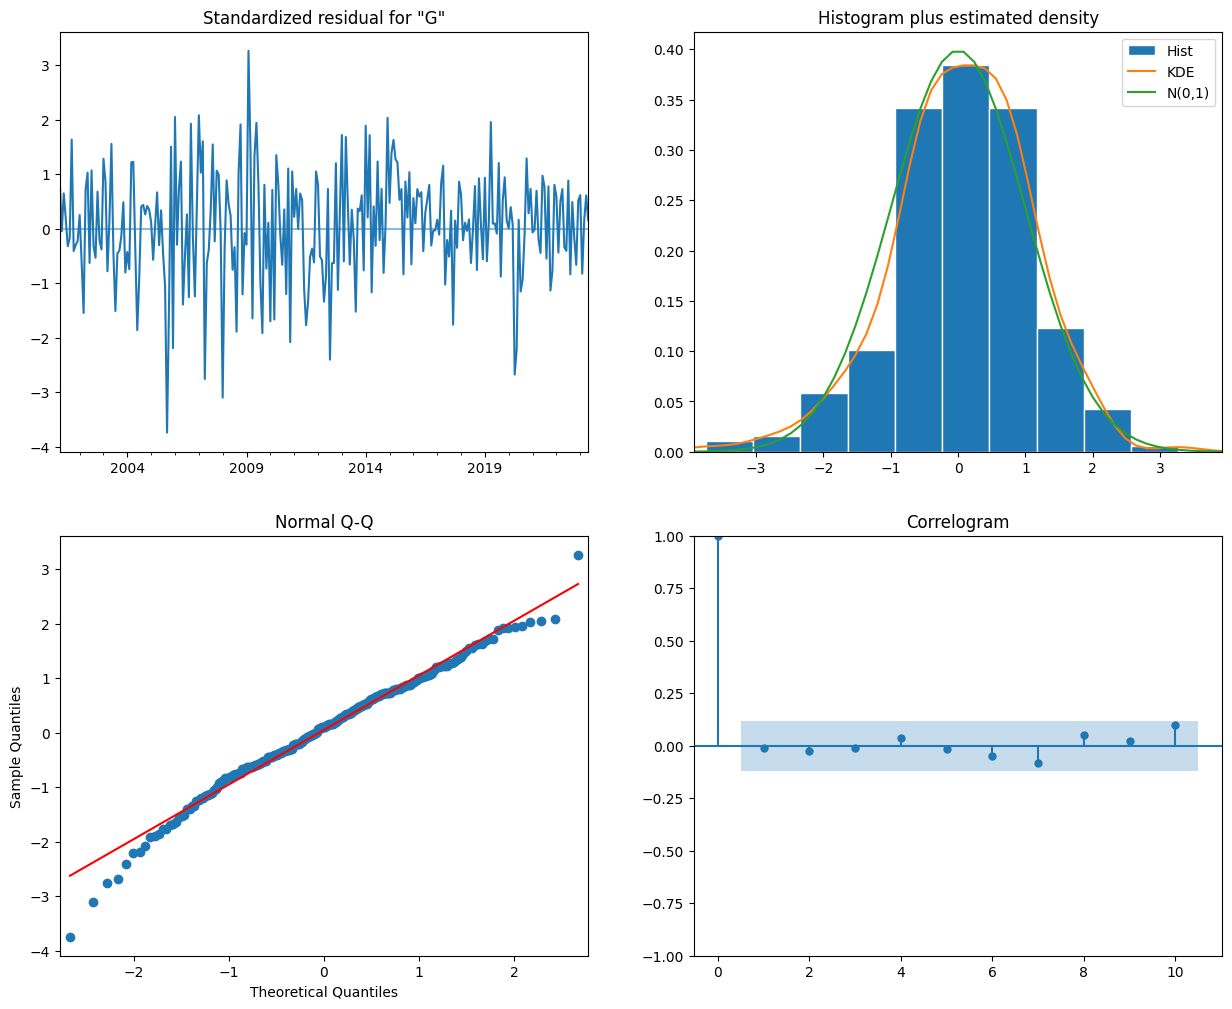

In [56]:
model = ARIMA(df_log_f_i, order=(5, 1, 5))  # p and q are the orders you've determined
results_515 = model.fit()
print(results_515.summary().tables[1])
results_515.plot_diagnostics(figsize=(15, 12))
plt.show()

In [57]:
print("AIC:", results_515.aic)
print("BIC:", results_515.bic)

AIC: 63.45498421019275
BIC: 102.91471945259549


En este modelo la representación de una distribución normal causada por los residuos se ve de una mejor manera. Esto tambien se ve representado en los valores de AIC y BIC los cuales son menores que los del modelo anterior. Por lo cual se puede decir que este modelo es mejor. 

# Prophet

In [195]:
df2 = pd.DataFrame(importacions_copy['Gasolina regular'])
df2 = df.reset_index()
df2 = df.rename(columns={'Fecha': 'ds',
                        'Gasolina regular': 'y'})

train2 = df[df['ds'] <= '2020-12-31']
test2 = df[(df['ds'] >= '2021-01-01') & (df['ds'] <= '2023-12-31')]

df2.tail(20)

,ds,y
249,2021-10-01,522701.11
250,2021-11-01,692267.31
251,2021-12-01,785313.56
252,2022-01-01,848902.97
253,2022-02-01,723925.74
254,2022-03-01,772406.10
255,2022-04-01,906104.05
256,2022-05-01,762776.12
257,2022-06-01,641348.46
258,2022-07-01,987872.05


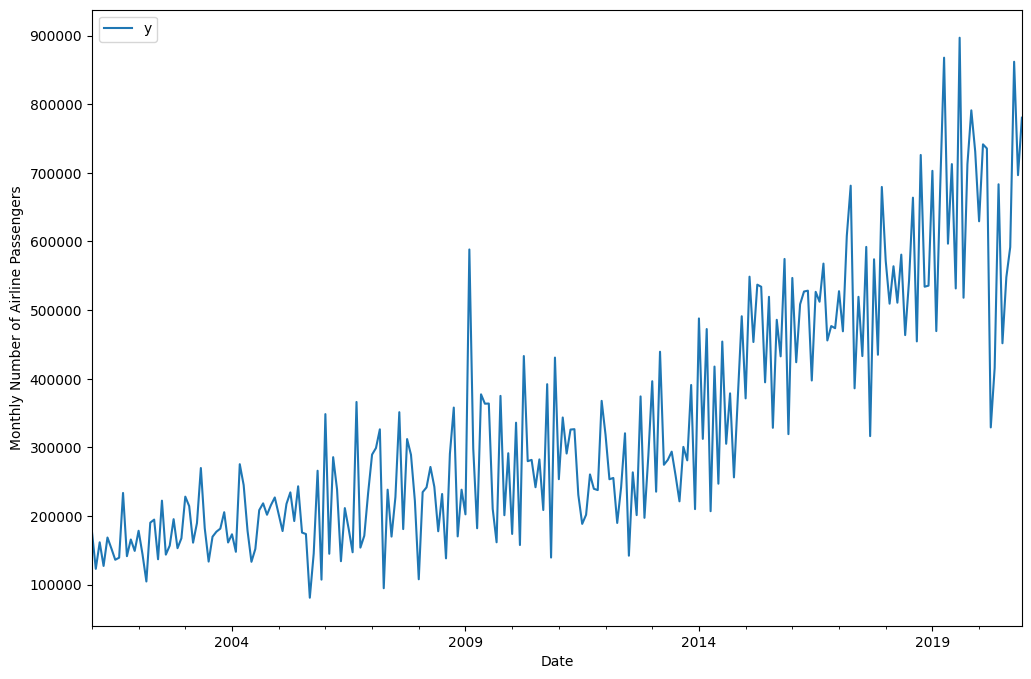

In [196]:
ax = train2.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')
plt.show()

In [199]:
m2 = Prophet()
m2.fit(train2)
future_dates2 = m.make_future_dataframe(periods=29, freq='MS')

04:22:42 - cmdstanpy - INFO - Chain [1] start processing
04:22:42 - cmdstanpy - INFO - Chain [1] done processing


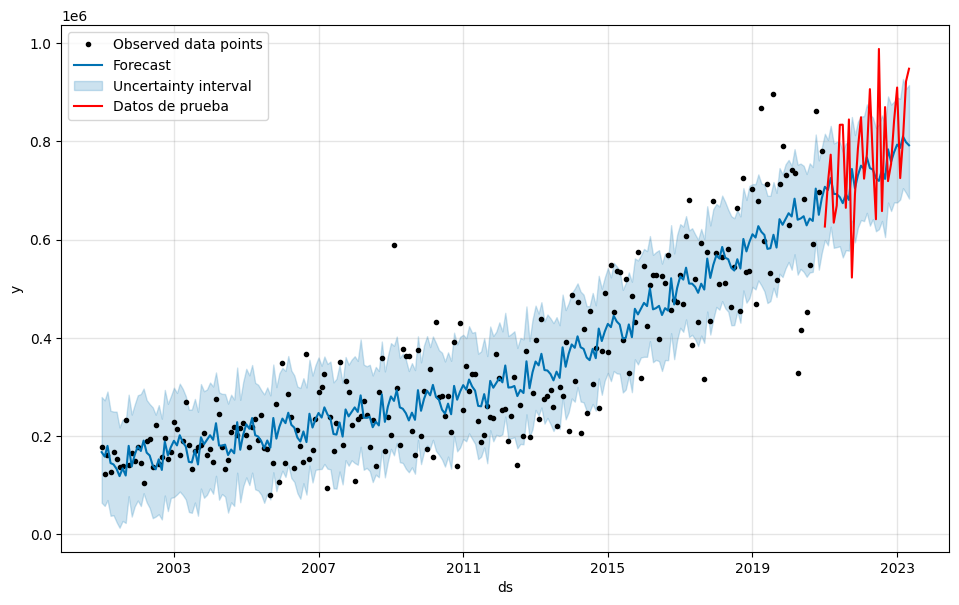

In [200]:
forecast2 = m2.predict(future_dates2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)
fig = m2.plot(forecast2)

# Agregar una línea continua para los datos de prueba al gráfico
plt.plot(test2['ds'], test2['y'], color='red', label='Datos de prueba')
plt.legend()
plt.show()

In [201]:
# Fusionar las predicciones con el conjunto de prueba
merged2 = forecast.merge(test2, on='ds', how='right')
rmse2 = np.sqrt(mean_squared_error(merged2['y'], merged2['yhat']))
print("RMSE:", rmse2)

RMSE: 109681.14236500017
